In [1]:
# import modules
import pandas
from sklearn import svm
import tensorflow as tf
import numpy as np
from sklearn.decomposition import PCA
from pylab import *
import struct
import keras as ks
import logging
from keras.layers import Dense, Activation, Flatten, Convolution2D
from keras.utils import np_utils
from keras.models import model_from_json
from keras import backend as K

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

import matplotlib.pyplot as plt
from skimage import io
import numpy as np
from PIL import Image 
from scipy import misc
import os
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
# ...

Using TensorFlow backend.


## 数据读取和预处理
label 3个 => 4个
- normal: 2462
- cpu   : 373
- mem   : 266
- io    : 592

In [2]:
# 3888 * 51 with 4 labels
data_raw = pandas.read_csv("data/host10280-labeled-2.csv")
data = np.array(data_raw)
data_raw = pandas.read_csv("data/host10274-labeled-2.csv")
data = np.concatenate((data,np.array(data_raw)),axis=0)
data_raw = pandas.read_csv("data/host10283-labeled-2.csv")
data = np.concatenate((data,np.array(data_raw)),axis=0)

# 50 = 2 ids + 45 features + 3 labels
# ids: host + clock
# labels: normal, cpu, mem, io
data_features = data[:,2:47]
data_labels = data[:,46:50]

len(data_labels)
for i in range(len(data_labels)):
    item = data_labels[i]
    if item[1] == 0 and item[2] == 0 and item[3] == 0:
        data_labels[i][0] = 1
    else:
        data_labels[i][0] = 0

data_class = [] # 0 ~ 3
for label in data_labels:
    data_class.append(np.dot([0,1,2,3],label))
data_class = np.array(data_class,dtype="int")

print(sum(data_class == 0))
print(sum(data_class == 1))
print(sum(data_class == 2))
print(sum(data_class == 3))
print(data_class.shape)

2462
373
266
592
(3693,)


In [3]:
# 1231 abnormal
num_sample = sum(data_class != 0)
# select 1231 normal samples randomly
data_tmp = data_features[data_class == 0]
index_tmp = np.arange(0,data_tmp.shape[0],data_tmp.shape[0]/num_sample)[0:num_sample]
data_normal_tmp = data_tmp[index_tmp]

data_features = np.concatenate((data_normal_tmp,                 data_features[data_class != 0]),axis=0)
data_labels   = np.concatenate((np.array([[1,0,0,0]]*num_sample),data_labels[data_class != 0]),  axis=0)
data_class    = np.concatenate((np.array([0]*num_sample),        data_class[data_class != 0]),   axis=0)

## 划分训练集和验证集
- 训练集: 80%
- 验证集: 20%

In [4]:
# feature scaling
for i in range(data_features.shape[1]):
    d_min = data_features[:,i].min()
    d_max = data_features[:,i].max()
    if d_min == d_max:
        data_features[:,i] = 1
        continue
    data_features[:,i] -= d_min
    data_features[:,i] /= (d_max - d_min)

num_tosample = len(data_class)
index_test = np.arange(0,num_tosample,5)
index_train = np.array(list(set(np.arange(0,num_tosample,1)) - set(index_test)))

data_train = data_features[index_train]
labels_train = data_labels[index_train]
class_train = data_class[index_train]
data_test = data_features[index_test]
labels_test = data_labels[index_test]
class_test = data_class[index_test]
print(data_train.shape)
print(labels_train.shape)
print(class_train.shape)
print(data_test.shape)
print(labels_test.shape)
print(class_test.shape)

(1969, 45)
(1969, 4)
(1969,)
(493, 45)
(493, 4)
(493,)


In [5]:
# save loss and acc
class LossHistory(ks.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        iindex = np.arange(0,len(self.losses[loss_type]),len(self.losses[loss_type])/200)
        iters = np.array(iters)
        plt.figure()
        # acc
        plt.plot(iters[iindex], np.array(self.accuracy[loss_type])[iindex], 'r', label='train acc')
        # loss
        plt.plot(iters[iindex], np.array(self.losses[loss_type])[iindex], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters[iindex], np.array(self.val_acc[loss_type])[iindex], 'b', label='val acc')
            # val_loss
            plt.plot(iters[iindex], np.array(self.val_loss[loss_type])[iindex], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        ylim(0,1.5)
        plt.legend(loc="upper right")
        plt.savefig('fig.png')
        
        plt.show()

## 神经网络
45 => 128 => 64 => 32 => 16 => 4

In [6]:
model = ks.models.Sequential()
model.add(Dense(128, input_dim=data_features.shape[1]))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dense(16))
model.add(Activation('relu'))
model.add(Dense(4))
model.add(Activation('softmax'))
history = LossHistory()

model.compile(loss='categorical_crossentropy',optimizer='adadelta',metrics=['accuracy'])
model.fit(x=data_train,y=labels_train,batch_size=128,nb_epoch=5000,verbose=1,validation_data=(data_test,labels_test),callbacks=[history])

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead


/Users/lyq/Anaconda/anaconda2/lib/python2.7/site-packages/keras/models.py:848: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1969 samples, validate on 493 samples
Epoch 1/5000
1969/1969 [==============================] - 0s - loss: 1.3174 - acc: 0.4261 - val_loss: 1.1665 - val_acc: 0.6633
Epoch 2/5000
1969/1969 [==============================] - 0s - loss: 1.0472 - acc: 0.6927 - val_loss: 0.9063 - val_acc: 0.6694
Epoch 3/5000
1969/1969 [==============================] - 0s - loss: 0.7714 - acc: 0.7679 - val_loss: 0.6640 - val_acc: 0.7830
Epoch 4/5000
1969/1969 [==============================] - 0s - loss: 0.6034 - acc: 0.7796 - val_loss: 0.4758 - val_acc: 0.8093
Epoch 5/5000
1969/1969 [==============================] - 0s - loss: 0.4395 - acc: 0.8106 - val_loss: 0.4027 - val_acc: 0.8114
Epoch 6/5000
1969/1969 [==============================] - 0s - loss: 0.3812 - acc: 0.8314 - val_loss: 0.3629 - val_acc: 0.8621
Epoch 7/5000
1969/1969 [==============================] - 0s - loss: 0.3470 - acc: 0.8603 - val_loss: 0.3314 - val_acc: 0.8600
Epoch 8/5000
1969/1969 [==============================] - 0s - l

1969/1969 [==============================] - 0s - loss: 0.2578 - acc: 0.8644 - val_loss: 0.2748 - val_acc: 0.8276
Epoch 65/5000
1969/1969 [==============================] - 0s - loss: 0.2639 - acc: 0.8603 - val_loss: 0.2930 - val_acc: 0.8600
Epoch 66/5000
1969/1969 [==============================] - 0s - loss: 0.2629 - acc: 0.8705 - val_loss: 0.2563 - val_acc: 0.9128
Epoch 67/5000
1969/1969 [==============================] - 0s - loss: 0.2584 - acc: 0.8603 - val_loss: 0.2679 - val_acc: 0.8276
Epoch 68/5000
1969/1969 [==============================] - 0s - loss: 0.2568 - acc: 0.8674 - val_loss: 0.2603 - val_acc: 0.8600
Epoch 69/5000
1969/1969 [==============================] - 0s - loss: 0.2519 - acc: 0.8812 - val_loss: 0.2528 - val_acc: 0.8742
Epoch 70/5000
1969/1969 [==============================] - 0s - loss: 0.2554 - acc: 0.8720 - val_loss: 0.2528 - val_acc: 0.9067
Epoch 71/5000
1969/1969 [==============================] - 0s - loss: 0.2535 - acc: 0.8730 - val_loss: 0.2654 - val_ac

1969/1969 [==============================] - 0s - loss: 0.2233 - acc: 0.8974 - val_loss: 0.2294 - val_acc: 0.8763
Epoch 128/5000
1969/1969 [==============================] - 0s - loss: 0.2215 - acc: 0.8913 - val_loss: 0.2071 - val_acc: 0.9209
Epoch 129/5000
1969/1969 [==============================] - 0s - loss: 0.2175 - acc: 0.9035 - val_loss: 0.2935 - val_acc: 0.83160.904
Epoch 130/5000
1969/1969 [==============================] - 0s - loss: 0.2282 - acc: 0.8923 - val_loss: 0.2057 - val_acc: 0.9209
Epoch 131/5000
1969/1969 [==============================] - 0s - loss: 0.2105 - acc: 0.9071 - val_loss: 0.2202 - val_acc: 0.8925
Epoch 132/5000
1969/1969 [==============================] - 0s - loss: 0.2072 - acc: 0.9045 - val_loss: 0.2153 - val_acc: 0.9168
Epoch 133/5000
1969/1969 [==============================] - 0s - loss: 0.2200 - acc: 0.9010 - val_loss: 0.2133 - val_acc: 0.9006
Epoch 134/5000
1969/1969 [==============================] - 0s - loss: 0.2161 - acc: 0.9025 - val_loss: 0.2

1969/1969 [==============================] - 0s - loss: 0.1891 - acc: 0.9106 - val_loss: 0.2228 - val_acc: 0.8621
Epoch 191/5000
1969/1969 [==============================] - 0s - loss: 0.1785 - acc: 0.9126 - val_loss: 0.2179 - val_acc: 0.8864
Epoch 192/5000
1969/1969 [==============================] - 0s - loss: 0.1888 - acc: 0.9162 - val_loss: 0.1663 - val_acc: 0.9310
Epoch 193/5000
1969/1969 [==============================] - 0s - loss: 0.1613 - acc: 0.9284 - val_loss: 0.1643 - val_acc: 0.9310
Epoch 194/5000
1969/1969 [==============================] - 0s - loss: 0.1788 - acc: 0.9192 - val_loss: 0.2005 - val_acc: 0.9006
Epoch 195/5000
1969/1969 [==============================] - 0s - loss: 0.1831 - acc: 0.9167 - val_loss: 0.1869 - val_acc: 0.9128
Epoch 196/5000
1969/1969 [==============================] - 0s - loss: 0.1720 - acc: 0.9208 - val_loss: 0.2176 - val_acc: 0.8641
Epoch 197/5000
1969/1969 [==============================] - 0s - loss: 0.1734 - acc: 0.9121 - val_loss: 0.1608 -

1969/1969 [==============================] - 0s - loss: 0.1375 - acc: 0.9431 - val_loss: 0.1809 - val_acc: 0.9148
Epoch 254/5000
1969/1969 [==============================] - 0s - loss: 0.1562 - acc: 0.9279 - val_loss: 0.1693 - val_acc: 0.9168
Epoch 255/5000
1969/1969 [==============================] - 0s - loss: 0.1591 - acc: 0.9223 - val_loss: 0.1494 - val_acc: 0.9249
Epoch 256/5000
1969/1969 [==============================] - 0s - loss: 0.1644 - acc: 0.9223 - val_loss: 0.1378 - val_acc: 0.9371
Epoch 257/5000
1969/1969 [==============================] - 0s - loss: 0.1311 - acc: 0.9416 - val_loss: 0.1723 - val_acc: 0.9108
Epoch 258/5000
1969/1969 [==============================] - 0s - loss: 0.1362 - acc: 0.9330 - val_loss: 0.1847 - val_acc: 0.9148
Epoch 259/5000
1969/1969 [==============================] - 0s - loss: 0.1433 - acc: 0.9350 - val_loss: 0.1945 - val_acc: 0.9148
Epoch 260/5000
1969/1969 [==============================] - 0s - loss: 0.1416 - acc: 0.9355 - val_loss: 0.1497 -

1969/1969 [==============================] - 0s - loss: 0.1249 - acc: 0.9380 - val_loss: 0.1816 - val_acc: 0.9148
Epoch 317/5000
1969/1969 [==============================] - 0s - loss: 0.1234 - acc: 0.9436 - val_loss: 0.3122 - val_acc: 0.8621
Epoch 318/5000
1969/1969 [==============================] - 0s - loss: 0.1426 - acc: 0.9289 - val_loss: 0.1184 - val_acc: 0.9513
Epoch 319/5000
1969/1969 [==============================] - 0s - loss: 0.1277 - acc: 0.9441 - val_loss: 0.1204 - val_acc: 0.9452
Epoch 320/5000
1969/1969 [==============================] - 0s - loss: 0.1386 - acc: 0.9340 - val_loss: 0.3006 - val_acc: 0.8641
Epoch 321/5000
1969/1969 [==============================] - 0s - loss: 0.1268 - acc: 0.9370 - val_loss: 0.1161 - val_acc: 0.9473
Epoch 322/5000
1969/1969 [==============================] - 0s - loss: 0.1242 - acc: 0.9406 - val_loss: 0.1561 - val_acc: 0.9229
Epoch 323/5000
1969/1969 [==============================] - 0s - loss: 0.1249 - acc: 0.9446 - val_loss: 0.1552 -

1969/1969 [==============================] - 0s - loss: 0.1372 - acc: 0.9330 - val_loss: 0.1200 - val_acc: 0.9371
Epoch 379/5000
1969/1969 [==============================] - 0s - loss: 0.1157 - acc: 0.9385 - val_loss: 0.2200 - val_acc: 0.9189
Epoch 380/5000
1969/1969 [==============================] - 0s - loss: 0.1228 - acc: 0.9436 - val_loss: 0.1815 - val_acc: 0.9168
Epoch 381/5000
1969/1969 [==============================] - 0s - loss: 0.1472 - acc: 0.9355 - val_loss: 0.1372 - val_acc: 0.9290
Epoch 382/5000
1969/1969 [==============================] - 0s - loss: 0.1153 - acc: 0.9436 - val_loss: 0.1729 - val_acc: 0.9148
Epoch 383/5000
1969/1969 [==============================] - 0s - loss: 0.1564 - acc: 0.9304 - val_loss: 0.1980 - val_acc: 0.9047
Epoch 384/5000
1969/1969 [==============================] - 0s - loss: 0.1341 - acc: 0.9350 - val_loss: 0.1114 - val_acc: 0.9533
Epoch 385/5000
1969/1969 [==============================] - 0s - loss: 0.1339 - acc: 0.9365 - val_loss: 0.1285 -

1969/1969 [==============================] - 0s - loss: 0.1106 - acc: 0.9426 - val_loss: 0.1271 - val_acc: 0.9371
Epoch 442/5000
1969/1969 [==============================] - 0s - loss: 0.1149 - acc: 0.9462 - val_loss: 0.1649 - val_acc: 0.9189
Epoch 443/5000
1969/1969 [==============================] - 0s - loss: 0.1331 - acc: 0.9360 - val_loss: 0.1414 - val_acc: 0.9351
Epoch 444/5000
1969/1969 [==============================] - 0s - loss: 0.1189 - acc: 0.9401 - val_loss: 0.1072 - val_acc: 0.9615
Epoch 445/5000
1969/1969 [==============================] - 0s - loss: 0.1136 - acc: 0.9467 - val_loss: 0.1531 - val_acc: 0.9270
Epoch 446/5000
1969/1969 [==============================] - 0s - loss: 0.1081 - acc: 0.9482 - val_loss: 0.1120 - val_acc: 0.9371
Epoch 447/5000
1969/1969 [==============================] - 0s - loss: 0.1206 - acc: 0.9421 - val_loss: 0.1953 - val_acc: 0.9168
Epoch 448/5000
1969/1969 [==============================] - 0s - loss: 0.1195 - acc: 0.9477 - val_loss: 0.1326 -

1969/1969 [==============================] - 0s - loss: 0.1093 - acc: 0.9441 - val_loss: 0.1616 - val_acc: 0.9209
Epoch 505/5000
1969/1969 [==============================] - 0s - loss: 0.1063 - acc: 0.9492 - val_loss: 0.1626 - val_acc: 0.9270
Epoch 506/5000
1969/1969 [==============================] - 0s - loss: 0.1190 - acc: 0.9416 - val_loss: 0.1207 - val_acc: 0.9533
Epoch 507/5000
1969/1969 [==============================] - 0s - loss: 0.1137 - acc: 0.9487 - val_loss: 0.2525 - val_acc: 0.8925
Epoch 508/5000
1969/1969 [==============================] - 0s - loss: 0.1452 - acc: 0.9335 - val_loss: 0.1335 - val_acc: 0.9432
Epoch 509/5000
1969/1969 [==============================] - 0s - loss: 0.1403 - acc: 0.9335 - val_loss: 0.1472 - val_acc: 0.9331
Epoch 510/5000
1969/1969 [==============================] - 0s - loss: 0.1193 - acc: 0.9431 - val_loss: 0.2441 - val_acc: 0.9026
Epoch 511/5000
1969/1969 [==============================] - 0s - loss: 0.1148 - acc: 0.9472 - val_loss: 0.1056 -

1969/1969 [==============================] - 0s - loss: 0.1206 - acc: 0.9426 - val_loss: 0.2422 - val_acc: 0.8986
Epoch 568/5000
1969/1969 [==============================] - 0s - loss: 0.1148 - acc: 0.9451 - val_loss: 0.1339 - val_acc: 0.9452
Epoch 569/5000
1969/1969 [==============================] - 0s - loss: 0.1205 - acc: 0.9401 - val_loss: 0.1527 - val_acc: 0.9270
Epoch 570/5000
1969/1969 [==============================] - 0s - loss: 0.1248 - acc: 0.9431 - val_loss: 0.1239 - val_acc: 0.9351
Epoch 571/5000
1969/1969 [==============================] - 0s - loss: 0.1087 - acc: 0.9462 - val_loss: 0.1144 - val_acc: 0.9554
Epoch 572/5000
1969/1969 [==============================] - 0s - loss: 0.1029 - acc: 0.9518 - val_loss: 0.1176 - val_acc: 0.9432
Epoch 573/5000
1969/1969 [==============================] - 0s - loss: 0.1134 - acc: 0.9492 - val_loss: 0.1242 - val_acc: 0.9412
Epoch 574/5000
1969/1969 [==============================] - 0s - loss: 0.1231 - acc: 0.9391 - val_loss: 0.1261 -

1969/1969 [==============================] - 0s - loss: 0.1181 - acc: 0.9441 - val_loss: 0.1159 - val_acc: 0.9371
Epoch 631/5000
1969/1969 [==============================] - 0s - loss: 0.1191 - acc: 0.9441 - val_loss: 0.1257 - val_acc: 0.9310
Epoch 632/5000
1969/1969 [==============================] - 0s - loss: 0.1029 - acc: 0.9451 - val_loss: 0.1091 - val_acc: 0.9452
Epoch 633/5000
1969/1969 [==============================] - 0s - loss: 0.1067 - acc: 0.9457 - val_loss: 0.2728 - val_acc: 0.8966
Epoch 634/5000
1969/1969 [==============================] - 0s - loss: 0.1245 - acc: 0.9416 - val_loss: 0.1024 - val_acc: 0.9473
Epoch 635/5000
1969/1969 [==============================] - 0s - loss: 0.1045 - acc: 0.9487 - val_loss: 0.2964 - val_acc: 0.8844
Epoch 636/5000
1969/1969 [==============================] - 0s - loss: 0.1230 - acc: 0.9406 - val_loss: 0.1303 - val_acc: 0.9371
Epoch 637/5000
1969/1969 [==============================] - 0s - loss: 0.1037 - acc: 0.9502 - val_loss: 0.1261 -

1969/1969 [==============================] - 0s - loss: 0.0939 - acc: 0.9584 - val_loss: 0.1057 - val_acc: 0.9452
Epoch 694/5000
1969/1969 [==============================] - 0s - loss: 0.1020 - acc: 0.9523 - val_loss: 0.1325 - val_acc: 0.9331
Epoch 695/5000
1969/1969 [==============================] - 0s - loss: 0.0990 - acc: 0.9543 - val_loss: 0.1270 - val_acc: 0.9351
Epoch 696/5000
1969/1969 [==============================] - 0s - loss: 0.0951 - acc: 0.9487 - val_loss: 0.1220 - val_acc: 0.9554
Epoch 697/5000
1969/1969 [==============================] - 0s - loss: 0.1250 - acc: 0.9360 - val_loss: 0.0988 - val_acc: 0.9533
Epoch 698/5000
1969/1969 [==============================] - 0s - loss: 0.1074 - acc: 0.9502 - val_loss: 0.1003 - val_acc: 0.9594
Epoch 699/5000
1969/1969 [==============================] - 0s - loss: 0.1066 - acc: 0.9467 - val_loss: 0.1538 - val_acc: 0.9229
Epoch 700/5000
1969/1969 [==============================] - 0s - loss: 0.1143 - acc: 0.9472 - val_loss: 0.1574 -

1969/1969 [==============================] - 0s - loss: 0.1105 - acc: 0.9446 - val_loss: 0.1524 - val_acc: 0.9270
Epoch 757/5000
1969/1969 [==============================] - 0s - loss: 0.0997 - acc: 0.9523 - val_loss: 0.1171 - val_acc: 0.9594
Epoch 758/5000
1969/1969 [==============================] - 0s - loss: 0.1022 - acc: 0.9533 - val_loss: 0.1437 - val_acc: 0.9331
Epoch 759/5000
1969/1969 [==============================] - 0s - loss: 0.0982 - acc: 0.9528 - val_loss: 0.0972 - val_acc: 0.9493
Epoch 760/5000
1969/1969 [==============================] - 0s - loss: 0.0993 - acc: 0.9533 - val_loss: 0.1290 - val_acc: 0.9371
Epoch 761/5000
1969/1969 [==============================] - 0s - loss: 0.1188 - acc: 0.9441 - val_loss: 0.2199 - val_acc: 0.9229
Epoch 762/5000
1969/1969 [==============================] - 0s - loss: 0.1036 - acc: 0.9523 - val_loss: 0.1148 - val_acc: 0.9351
Epoch 763/5000
1969/1969 [==============================] - 0s - loss: 0.1085 - acc: 0.9451 - val_loss: 0.1132 -

1969/1969 [==============================] - 0s - loss: 0.0946 - acc: 0.9553 - val_loss: 0.1848 - val_acc: 0.9249
Epoch 820/5000
1969/1969 [==============================] - 0s - loss: 0.1080 - acc: 0.9533 - val_loss: 0.0999 - val_acc: 0.9452
Epoch 821/5000
1969/1969 [==============================] - 0s - loss: 0.0902 - acc: 0.9563 - val_loss: 0.0966 - val_acc: 0.9493
Epoch 822/5000
1969/1969 [==============================] - ETA: 0s - loss: 0.0688 - acc: 0.960 - 0s - loss: 0.0930 - acc: 0.9573 - val_loss: 0.1187 - val_acc: 0.9574
Epoch 823/5000
1969/1969 [==============================] - 0s - loss: 0.1022 - acc: 0.9507 - val_loss: 0.2140 - val_acc: 0.9148
Epoch 824/5000
1969/1969 [==============================] - 0s - loss: 0.1024 - acc: 0.9482 - val_loss: 0.1073 - val_acc: 0.9371
Epoch 825/5000
1969/1969 [==============================] - 0s - loss: 0.1059 - acc: 0.9487 - val_loss: 0.1479 - val_acc: 0.9331
Epoch 826/5000
1969/1969 [==============================] - 0s - loss: 0.0

1969/1969 [==============================] - 0s - loss: 0.0915 - acc: 0.9558 - val_loss: 0.1011 - val_acc: 0.9412
Epoch 883/5000
1969/1969 [==============================] - 0s - loss: 0.1006 - acc: 0.9512 - val_loss: 0.1562 - val_acc: 0.9351
Epoch 884/5000
1969/1969 [==============================] - 0s - loss: 0.1048 - acc: 0.9523 - val_loss: 0.1372 - val_acc: 0.9310
Epoch 885/5000
1969/1969 [==============================] - 0s - loss: 0.0935 - acc: 0.9512 - val_loss: 0.1106 - val_acc: 0.9432
Epoch 886/5000
1969/1969 [==============================] - 0s - loss: 0.1029 - acc: 0.9548 - val_loss: 0.1497 - val_acc: 0.9331
Epoch 887/5000
1969/1969 [==============================] - 0s - loss: 0.1151 - acc: 0.9497 - val_loss: 0.1102 - val_acc: 0.9554
Epoch 888/5000
1969/1969 [==============================] - 0s - loss: 0.1112 - acc: 0.9512 - val_loss: 0.0975 - val_acc: 0.9493
Epoch 889/5000
1969/1969 [==============================] - 0s - loss: 0.0970 - acc: 0.9543 - val_loss: 0.1145 -

1969/1969 [==============================] - 0s - loss: 0.0930 - acc: 0.9518 - val_loss: 0.1254 - val_acc: 0.9331
Epoch 946/5000
1969/1969 [==============================] - 0s - loss: 0.1098 - acc: 0.9462 - val_loss: 0.1136 - val_acc: 0.9513
Epoch 947/5000
1969/1969 [==============================] - 0s - loss: 0.0953 - acc: 0.9573 - val_loss: 0.1132 - val_acc: 0.9473
Epoch 948/5000
1969/1969 [==============================] - 0s - loss: 0.1016 - acc: 0.9497 - val_loss: 0.1135 - val_acc: 0.9391
Epoch 949/5000
1969/1969 [==============================] - 0s - loss: 0.0970 - acc: 0.9538 - val_loss: 0.0954 - val_acc: 0.9513
Epoch 950/5000
1969/1969 [==============================] - 0s - loss: 0.0958 - acc: 0.9538 - val_loss: 0.1379 - val_acc: 0.9351
Epoch 951/5000
1969/1969 [==============================] - 0s - loss: 0.0999 - acc: 0.9518 - val_loss: 0.1162 - val_acc: 0.9391
Epoch 952/5000
1969/1969 [==============================] - 0s - loss: 0.1184 - acc: 0.9477 - val_loss: 0.1026 -

1969/1969 [==============================] - 0s - loss: 0.0994 - acc: 0.9523 - val_loss: 0.1100 - val_acc: 0.9513
Epoch 1008/5000
1969/1969 [==============================] - 0s - loss: 0.0932 - acc: 0.9533 - val_loss: 0.2094 - val_acc: 0.9209
Epoch 1009/5000
1969/1969 [==============================] - 0s - loss: 0.1103 - acc: 0.9512 - val_loss: 0.1002 - val_acc: 0.9432
Epoch 1010/5000
1969/1969 [==============================] - 0s - loss: 0.0993 - acc: 0.9553 - val_loss: 0.1935 - val_acc: 0.9229
Epoch 1011/5000
1969/1969 [==============================] - 0s - loss: 0.1103 - acc: 0.9467 - val_loss: 0.0948 - val_acc: 0.9615
Epoch 1012/5000
1969/1969 [==============================] - 0s - loss: 0.0911 - acc: 0.9614 - val_loss: 0.0937 - val_acc: 0.9533
Epoch 1013/5000
1969/1969 [==============================] - 0s - loss: 0.0979 - acc: 0.9467 - val_loss: 0.0971 - val_acc: 0.9493
Epoch 1014/5000
1969/1969 [==============================] - 0s - loss: 0.1091 - acc: 0.9487 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0891 - acc: 0.9609 - val_loss: 0.1694 - val_acc: 0.9290
Epoch 1071/5000
1969/1969 [==============================] - 0s - loss: 0.1075 - acc: 0.9426 - val_loss: 0.1140 - val_acc: 0.9554
Epoch 1072/5000
1969/1969 [==============================] - 0s - loss: 0.0956 - acc: 0.9558 - val_loss: 0.1747 - val_acc: 0.9270
Epoch 1073/5000
1969/1969 [==============================] - 0s - loss: 0.0944 - acc: 0.9538 - val_loss: 0.0905 - val_acc: 0.9594
Epoch 1074/5000
1969/1969 [==============================] - 0s - loss: 0.0984 - acc: 0.9538 - val_loss: 0.1218 - val_acc: 0.9493
Epoch 1075/5000
1969/1969 [==============================] - ETA: 0s - loss: 0.0955 - acc: 0.956 - 0s - loss: 0.0946 - acc: 0.9563 - val_loss: 0.0983 - val_acc: 0.9554
Epoch 1076/5000
1969/1969 [==============================] - 0s - loss: 0.0969 - acc: 0.9507 - val_loss: 0.1370 - val_acc: 0.9351
Epoch 1077/5000
1969/1969 [==============================] - 0s - lo

1969/1969 [==============================] - 0s - loss: 0.0908 - acc: 0.9563 - val_loss: 0.1279 - val_acc: 0.9351
Epoch 1133/5000
1969/1969 [==============================] - 0s - loss: 0.0969 - acc: 0.9614 - val_loss: 0.1182 - val_acc: 0.9473
Epoch 1134/5000
1969/1969 [==============================] - 0s - loss: 0.0902 - acc: 0.9523 - val_loss: 0.1057 - val_acc: 0.9473
Epoch 1135/5000
1969/1969 [==============================] - 0s - loss: 0.1093 - acc: 0.9431 - val_loss: 0.1114 - val_acc: 0.9554
Epoch 1136/5000
1969/1969 [==============================] - 0s - loss: 0.0899 - acc: 0.9568 - val_loss: 0.0969 - val_acc: 0.9513
Epoch 1137/5000
1969/1969 [==============================] - 0s - loss: 0.0987 - acc: 0.9512 - val_loss: 0.0959 - val_acc: 0.9615
Epoch 1138/5000
1969/1969 [==============================] - 0s - loss: 0.0914 - acc: 0.9589 - val_loss: 0.1931 - val_acc: 0.9310
Epoch 1139/5000
1969/1969 [==============================] - 0s - loss: 0.1040 - acc: 0.9538 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0921 - acc: 0.9533 - val_loss: 0.1349 - val_acc: 0.9351
Epoch 1196/5000
1969/1969 [==============================] - 0s - loss: 0.1081 - acc: 0.9528 - val_loss: 0.0996 - val_acc: 0.9635
Epoch 1197/5000
1969/1969 [==============================] - 0s - loss: 0.0891 - acc: 0.9584 - val_loss: 0.0984 - val_acc: 0.9594
Epoch 1198/5000
1969/1969 [==============================] - 0s - loss: 0.0857 - acc: 0.9594 - val_loss: 0.0953 - val_acc: 0.9493
Epoch 1199/5000
1969/1969 [==============================] - 0s - loss: 0.0946 - acc: 0.9523 - val_loss: 0.0940 - val_acc: 0.9533
Epoch 1200/5000
1969/1969 [==============================] - 0s - loss: 0.0905 - acc: 0.9543 - val_loss: 0.0884 - val_acc: 0.9594
Epoch 1201/5000
1969/1969 [==============================] - 0s - loss: 0.0952 - acc: 0.9533 - val_loss: 0.0859 - val_acc: 0.9615
Epoch 1202/5000
1969/1969 [==============================] - 0s - loss: 0.0841 - acc: 0.9584 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0877 - acc: 0.9644 - val_loss: 0.0932 - val_acc: 0.9635
Epoch 1258/5000
1969/1969 [==============================] - 0s - loss: 0.1080 - acc: 0.9492 - val_loss: 0.1190 - val_acc: 0.9391
Epoch 1259/5000
1969/1969 [==============================] - 0s - loss: 0.0882 - acc: 0.9589 - val_loss: 0.0962 - val_acc: 0.9452
Epoch 1260/5000
1969/1969 [==============================] - 0s - loss: 0.0970 - acc: 0.9507 - val_loss: 0.1003 - val_acc: 0.9574
Epoch 1261/5000
1969/1969 [==============================] - 0s - loss: 0.0920 - acc: 0.9578 - val_loss: 0.1025 - val_acc: 0.9452
Epoch 1262/5000
1969/1969 [==============================] - 0s - loss: 0.0904 - acc: 0.9589 - val_loss: 0.0967 - val_acc: 0.9533
Epoch 1263/5000
1969/1969 [==============================] - 0s - loss: 0.0853 - acc: 0.9609 - val_loss: 0.1217 - val_acc: 0.9371
Epoch 1264/5000
1969/1969 [==============================] - 0s - loss: 0.0921 - acc: 0.9533 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0892 - acc: 0.9568 - val_loss: 0.1032 - val_acc: 0.9594
Epoch 1321/5000
1969/1969 [==============================] - 0s - loss: 0.0893 - acc: 0.9558 - val_loss: 0.1334 - val_acc: 0.9493
Epoch 1322/5000
1969/1969 [==============================] - 0s - loss: 0.0825 - acc: 0.9584 - val_loss: 0.1432 - val_acc: 0.9310
Epoch 1323/5000
1969/1969 [==============================] - 0s - loss: 0.0951 - acc: 0.9548 - val_loss: 0.0909 - val_acc: 0.9696
Epoch 1324/5000
1969/1969 [==============================] - 0s - loss: 0.0871 - acc: 0.9609 - val_loss: 0.1121 - val_acc: 0.9412
Epoch 1325/5000
1969/1969 [==============================] - 0s - loss: 0.0959 - acc: 0.9548 - val_loss: 0.0901 - val_acc: 0.9574
Epoch 1326/5000
1969/1969 [==============================] - 0s - loss: 0.0970 - acc: 0.9558 - val_loss: 0.1117 - val_acc: 0.9493
Epoch 1327/5000
1969/1969 [==============================] - 0s - loss: 0.0908 - acc: 0.9563 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.1081 - acc: 0.9512 - val_loss: 0.0961 - val_acc: 0.9594
Epoch 1384/5000
1969/1969 [==============================] - 0s - loss: 0.0871 - acc: 0.9578 - val_loss: 0.1375 - val_acc: 0.9473
Epoch 1385/5000
1969/1969 [==============================] - 0s - loss: 0.0949 - acc: 0.9538 - val_loss: 0.0918 - val_acc: 0.9615
Epoch 1386/5000
1969/1969 [==============================] - 0s - loss: 0.0894 - acc: 0.9518 - val_loss: 0.1474 - val_acc: 0.9310
Epoch 1387/5000
1969/1969 [==============================] - 0s - loss: 0.0889 - acc: 0.9543 - val_loss: 0.0846 - val_acc: 0.9655
Epoch 1388/5000
1969/1969 [==============================] - 0s - loss: 0.0836 - acc: 0.9604 - val_loss: 0.1252 - val_acc: 0.9391
Epoch 1389/5000
1969/1969 [==============================] - 0s - loss: 0.0880 - acc: 0.9563 - val_loss: 0.1105 - val_acc: 0.9473
Epoch 1390/5000
1969/1969 [==============================] - 0s - loss: 0.0856 - acc: 0.9650 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0905 - acc: 0.9594 - val_loss: 0.1151 - val_acc: 0.9493
Epoch 1447/5000
1969/1969 [==============================] - 0s - loss: 0.0867 - acc: 0.9589 - val_loss: 0.1140 - val_acc: 0.9432
Epoch 1448/5000
1969/1969 [==============================] - 0s - loss: 0.1078 - acc: 0.9457 - val_loss: 0.1324 - val_acc: 0.9351
Epoch 1449/5000
1969/1969 [==============================] - 0s - loss: 0.0894 - acc: 0.9604 - val_loss: 0.1008 - val_acc: 0.9513
Epoch 1450/5000
1969/1969 [==============================] - 0s - loss: 0.0873 - acc: 0.9614 - val_loss: 0.0914 - val_acc: 0.9533
Epoch 1451/5000
1969/1969 [==============================] - 0s - loss: 0.0873 - acc: 0.9558 - val_loss: 0.1130 - val_acc: 0.9493
Epoch 1452/5000
1969/1969 [==============================] - 0s - loss: 0.0921 - acc: 0.9543 - val_loss: 0.0961 - val_acc: 0.9452
Epoch 1453/5000
1969/1969 [==============================] - 0s - loss: 0.0848 - acc: 0.9624 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0879 - acc: 0.9609 - val_loss: 0.1002 - val_acc: 0.9493
Epoch 1509/5000
1969/1969 [==============================] - 0s - loss: 0.0872 - acc: 0.9619 - val_loss: 0.0952 - val_acc: 0.9655
Epoch 1510/5000
1969/1969 [==============================] - 0s - loss: 0.0845 - acc: 0.9584 - val_loss: 0.1733 - val_acc: 0.9249
Epoch 1511/5000
1969/1969 [==============================] - 0s - loss: 0.0864 - acc: 0.9589 - val_loss: 0.1031 - val_acc: 0.9615
Epoch 1512/5000
1969/1969 [==============================] - 0s - loss: 0.0864 - acc: 0.9599 - val_loss: 0.0913 - val_acc: 0.9493
Epoch 1513/5000
1969/1969 [==============================] - 0s - loss: 0.0886 - acc: 0.9624 - val_loss: 0.1074 - val_acc: 0.9533
Epoch 1514/5000
1969/1969 [==============================] - 0s - loss: 0.1111 - acc: 0.9492 - val_loss: 0.1206 - val_acc: 0.9473
Epoch 1515/5000
1969/1969 [==============================] - 0s - loss: 0.0858 - acc: 0.9573 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0973 - acc: 0.9548 - val_loss: 0.1004 - val_acc: 0.9594
Epoch 1572/5000
1969/1969 [==============================] - 0s - loss: 0.0847 - acc: 0.9578 - val_loss: 0.1444 - val_acc: 0.9290
Epoch 1573/5000
1969/1969 [==============================] - 0s - loss: 0.0911 - acc: 0.9573 - val_loss: 0.1118 - val_acc: 0.9493
Epoch 1574/5000
1969/1969 [==============================] - 0s - loss: 0.0810 - acc: 0.9609 - val_loss: 0.1223 - val_acc: 0.9351
Epoch 1575/5000
1969/1969 [==============================] - 0s - loss: 0.0783 - acc: 0.9609 - val_loss: 0.1113 - val_acc: 0.9432
Epoch 1576/5000
1969/1969 [==============================] - 0s - loss: 0.0873 - acc: 0.9563 - val_loss: 0.1155 - val_acc: 0.9371
Epoch 1577/5000
1969/1969 [==============================] - 0s - loss: 0.0973 - acc: 0.9502 - val_loss: 0.1105 - val_acc: 0.9574
Epoch 1578/5000
1969/1969 [==============================] - 0s - loss: 0.0843 - acc: 0.9568 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0952 - acc: 0.9568 - val_loss: 0.0929 - val_acc: 0.9574
Epoch 1634/5000
1969/1969 [==============================] - 0s - loss: 0.0809 - acc: 0.9624 - val_loss: 0.1323 - val_acc: 0.9452
Epoch 1635/5000
1969/1969 [==============================] - 0s - loss: 0.0858 - acc: 0.9594 - val_loss: 0.1754 - val_acc: 0.9351
Epoch 1636/5000
1969/1969 [==============================] - 0s - loss: 0.0961 - acc: 0.9553 - val_loss: 0.0888 - val_acc: 0.9635
Epoch 1637/5000
1969/1969 [==============================] - 0s - loss: 0.0776 - acc: 0.9655 - val_loss: 0.1210 - val_acc: 0.9391
Epoch 1638/5000
1969/1969 [==============================] - 0s - loss: 0.0899 - acc: 0.9548 - val_loss: 0.0889 - val_acc: 0.9615
Epoch 1639/5000
1969/1969 [==============================] - 0s - loss: 0.0949 - acc: 0.9543 - val_loss: 0.1363 - val_acc: 0.9391
Epoch 1640/5000
1969/1969 [==============================] - 0s - loss: 0.0889 - acc: 0.9568 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0962 - acc: 0.9563 - val_loss: 0.1295 - val_acc: 0.9533
Epoch 1697/5000
1969/1969 [==============================] - 0s - loss: 0.0874 - acc: 0.9553 - val_loss: 0.0870 - val_acc: 0.9675
Epoch 1698/5000
1969/1969 [==============================] - 0s - loss: 0.0808 - acc: 0.9609 - val_loss: 0.1390 - val_acc: 0.9371
Epoch 1699/5000
1969/1969 [==============================] - 0s - loss: 0.0866 - acc: 0.9624 - val_loss: 0.0961 - val_acc: 0.9554
Epoch 1700/5000
1969/1969 [==============================] - 0s - loss: 0.0819 - acc: 0.9578 - val_loss: 0.2200 - val_acc: 0.9209
Epoch 1701/5000
1969/1969 [==============================] - 0s - loss: 0.0945 - acc: 0.9594 - val_loss: 0.0904 - val_acc: 0.9696
Epoch 1702/5000
1969/1969 [==============================] - 0s - loss: 0.0795 - acc: 0.9650 - val_loss: 0.1095 - val_acc: 0.9533
Epoch 1703/5000
1969/1969 [==============================] - 0s - loss: 0.0874 - acc: 0.9563 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0847 - acc: 0.9604 - val_loss: 0.0968 - val_acc: 0.9635
Epoch 1760/5000
1969/1969 [==============================] - 0s - loss: 0.1034 - acc: 0.9518 - val_loss: 0.0895 - val_acc: 0.9615
Epoch 1761/5000
1969/1969 [==============================] - 0s - loss: 0.0852 - acc: 0.9614 - val_loss: 0.1363 - val_acc: 0.9331
Epoch 1762/5000
1969/1969 [==============================] - 0s - loss: 0.1063 - acc: 0.9538 - val_loss: 0.0868 - val_acc: 0.9635
Epoch 1763/5000
1969/1969 [==============================] - 0s - loss: 0.0838 - acc: 0.9578 - val_loss: 0.0861 - val_acc: 0.9635
Epoch 1764/5000
1969/1969 [==============================] - 0s - loss: 0.0883 - acc: 0.9543 - val_loss: 0.0905 - val_acc: 0.9696
Epoch 1765/5000
1969/1969 [==============================] - 0s - loss: 0.0863 - acc: 0.9538 - val_loss: 0.1038 - val_acc: 0.9432
Epoch 1766/5000
1969/1969 [==============================] - 0s - loss: 0.0820 - acc: 0.9584 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0808 - acc: 0.9619 - val_loss: 0.1120 - val_acc: 0.9493
Epoch 1823/5000
1969/1969 [==============================] - 0s - loss: 0.0961 - acc: 0.9644 - val_loss: 0.0953 - val_acc: 0.9554
Epoch 1824/5000
1969/1969 [==============================] - 0s - loss: 0.0829 - acc: 0.9589 - val_loss: 0.1086 - val_acc: 0.9452
Epoch 1825/5000
1969/1969 [==============================] - 0s - loss: 0.0832 - acc: 0.9584 - val_loss: 0.0964 - val_acc: 0.9675
Epoch 1826/5000
1969/1969 [==============================] - 0s - loss: 0.0923 - acc: 0.9568 - val_loss: 0.0979 - val_acc: 0.9554
Epoch 1827/5000
1969/1969 [==============================] - 0s - loss: 0.0766 - acc: 0.9660 - val_loss: 0.1012 - val_acc: 0.9533
Epoch 1828/5000
1969/1969 [==============================] - 0s - loss: 0.0783 - acc: 0.9644 - val_loss: 0.1067 - val_acc: 0.9594
Epoch 1829/5000
1969/1969 [==============================] - 0s - loss: 0.0805 - acc: 0.9644 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0771 - acc: 0.9660 - val_loss: 0.1101 - val_acc: 0.9554
Epoch 1886/5000
1969/1969 [==============================] - 0s - loss: 0.0831 - acc: 0.9594 - val_loss: 0.1198 - val_acc: 0.9432
Epoch 1887/5000
1969/1969 [==============================] - 0s - loss: 0.0771 - acc: 0.9675 - val_loss: 0.1779 - val_acc: 0.9270
Epoch 1888/5000
1969/1969 [==============================] - 0s - loss: 0.0816 - acc: 0.9624 - val_loss: 0.1044 - val_acc: 0.9513
Epoch 1889/5000
1969/1969 [==============================] - 0s - loss: 0.0755 - acc: 0.9634 - val_loss: 0.1805 - val_acc: 0.9270
Epoch 1890/5000
1969/1969 [==============================] - 0s - loss: 0.0911 - acc: 0.9573 - val_loss: 0.0963 - val_acc: 0.9655
Epoch 1891/5000
1969/1969 [==============================] - 0s - loss: 0.0832 - acc: 0.9594 - val_loss: 0.0903 - val_acc: 0.9696
Epoch 1892/5000
1969/1969 [==============================] - 0s - loss: 0.0812 - acc: 0.9614 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0903 - acc: 0.9563 - val_loss: 0.1078 - val_acc: 0.9594
Epoch 1947/5000
1969/1969 [==============================] - 0s - loss: 0.0800 - acc: 0.9624 - val_loss: 0.1726 - val_acc: 0.9351
Epoch 1948/5000
1969/1969 [==============================] - 0s - loss: 0.0895 - acc: 0.9609 - val_loss: 0.1102 - val_acc: 0.9493
Epoch 1949/5000
1969/1969 [==============================] - 0s - loss: 0.0773 - acc: 0.9629 - val_loss: 0.1426 - val_acc: 0.9351
Epoch 1950/5000
1969/1969 [==============================] - 0s - loss: 0.0792 - acc: 0.9634 - val_loss: 0.0934 - val_acc: 0.9554
Epoch 1951/5000
1969/1969 [==============================] - 0s - loss: 0.0761 - acc: 0.9670 - val_loss: 0.1000 - val_acc: 0.9513
Epoch 1952/5000
1969/1969 [==============================] - 0s - loss: 0.0825 - acc: 0.9634 - val_loss: 0.0950 - val_acc: 0.9574
Epoch 1953/5000
1969/1969 [==============================] - 0s - loss: 0.0810 - acc: 0.9619 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0769 - acc: 0.9634 - val_loss: 0.0968 - val_acc: 0.9675
Epoch 2009/5000
1969/1969 [==============================] - 0s - loss: 0.0780 - acc: 0.9660 - val_loss: 0.1260 - val_acc: 0.9391
Epoch 2010/5000
1969/1969 [==============================] - 0s - loss: 0.0858 - acc: 0.9548 - val_loss: 0.1365 - val_acc: 0.9391
Epoch 2011/5000
1969/1969 [==============================] - 0s - loss: 0.0831 - acc: 0.9609 - val_loss: 0.1165 - val_acc: 0.9371
Epoch 2012/5000
1969/1969 [==============================] - 0s - loss: 0.0766 - acc: 0.9629 - val_loss: 0.1064 - val_acc: 0.9452
Epoch 2013/5000
1969/1969 [==============================] - 0s - loss: 0.0795 - acc: 0.9624 - val_loss: 0.1283 - val_acc: 0.9371
Epoch 2014/5000
1969/1969 [==============================] - 0s - loss: 0.0753 - acc: 0.9665 - val_loss: 0.0967 - val_acc: 0.9533
Epoch 2015/5000
1969/1969 [==============================] - 0s - loss: 0.0827 - acc: 0.9604 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0750 - acc: 0.9650 - val_loss: 0.0955 - val_acc: 0.9655
Epoch 2072/5000
1969/1969 [==============================] - 0s - loss: 0.0827 - acc: 0.9639 - val_loss: 0.1021 - val_acc: 0.9533
Epoch 2073/5000
1969/1969 [==============================] - 0s - loss: 0.0848 - acc: 0.9634 - val_loss: 0.1198 - val_acc: 0.9594
Epoch 2074/5000
1969/1969 [==============================] - 0s - loss: 0.0800 - acc: 0.9639 - val_loss: 0.0971 - val_acc: 0.9675
Epoch 2075/5000
1969/1969 [==============================] - 0s - loss: 0.0759 - acc: 0.9639 - val_loss: 0.0972 - val_acc: 0.9615
Epoch 2076/5000
1969/1969 [==============================] - 0s - loss: 0.0812 - acc: 0.9639 - val_loss: 0.2315 - val_acc: 0.9189
Epoch 2077/5000
1969/1969 [==============================] - 0s - loss: 0.0867 - acc: 0.9604 - val_loss: 0.1588 - val_acc: 0.9310
Epoch 2078/5000
1969/1969 [==============================] - 0s - loss: 0.0761 - acc: 0.9655 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0731 - acc: 0.9639 - val_loss: 0.1117 - val_acc: 0.9513
Epoch 2134/5000
1969/1969 [==============================] - 0s - loss: 0.0745 - acc: 0.9655 - val_loss: 0.0854 - val_acc: 0.9675
Epoch 2135/5000
1969/1969 [==============================] - 0s - loss: 0.0721 - acc: 0.9680 - val_loss: 0.1174 - val_acc: 0.9493
Epoch 2136/5000
1969/1969 [==============================] - 0s - loss: 0.0766 - acc: 0.9619 - val_loss: 0.1023 - val_acc: 0.9615
Epoch 2137/5000
1969/1969 [==============================] - 0s - loss: 0.0764 - acc: 0.9655 - val_loss: 0.1072 - val_acc: 0.9513
Epoch 2138/5000
1969/1969 [==============================] - 0s - loss: 0.0780 - acc: 0.9629 - val_loss: 0.1498 - val_acc: 0.9331
Epoch 2139/5000
1969/1969 [==============================] - 0s - loss: 0.0830 - acc: 0.9644 - val_loss: 0.1399 - val_acc: 0.9391
Epoch 2140/5000
1969/1969 [==============================] - 0s - loss: 0.0726 - acc: 0.9675 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0813 - acc: 0.9614 - val_loss: 0.0888 - val_acc: 0.9696
Epoch 2196/5000
1969/1969 [==============================] - 0s - loss: 0.0759 - acc: 0.9644 - val_loss: 0.1473 - val_acc: 0.9432
Epoch 2197/5000
1969/1969 [==============================] - 0s - loss: 0.0858 - acc: 0.9573 - val_loss: 0.1607 - val_acc: 0.9412
Epoch 2198/5000
1969/1969 [==============================] - 0s - loss: 0.0765 - acc: 0.9624 - val_loss: 0.0903 - val_acc: 0.9736
Epoch 2199/5000
1969/1969 [==============================] - 0s - loss: 0.0774 - acc: 0.9604 - val_loss: 0.0875 - val_acc: 0.9736
Epoch 2200/5000
1969/1969 [==============================] - 0s - loss: 0.0749 - acc: 0.9644 - val_loss: 0.0969 - val_acc: 0.9655
Epoch 2201/5000
1969/1969 [==============================] - 0s - loss: 0.0738 - acc: 0.9655 - val_loss: 0.1015 - val_acc: 0.9554
Epoch 2202/5000
1969/1969 [==============================] - 0s - loss: 0.0818 - acc: 0.9614 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0696 - acc: 0.9695 - val_loss: 0.1326 - val_acc: 0.9432
Epoch 2259/5000
1969/1969 [==============================] - 0s - loss: 0.0811 - acc: 0.9639 - val_loss: 0.1276 - val_acc: 0.9452
Epoch 2260/5000
1969/1969 [==============================] - 0s - loss: 0.0782 - acc: 0.9695 - val_loss: 0.1406 - val_acc: 0.9391
Epoch 2261/5000
1969/1969 [==============================] - 0s - loss: 0.0782 - acc: 0.9619 - val_loss: 0.1156 - val_acc: 0.9594
Epoch 2262/5000
1969/1969 [==============================] - 0s - loss: 0.0790 - acc: 0.9639 - val_loss: 0.1007 - val_acc: 0.9615
Epoch 2263/5000
1969/1969 [==============================] - 0s - loss: 0.0850 - acc: 0.9589 - val_loss: 0.0883 - val_acc: 0.9696
Epoch 2264/5000
1969/1969 [==============================] - 0s - loss: 0.0758 - acc: 0.9644 - val_loss: 0.1080 - val_acc: 0.9533
Epoch 2265/5000
1969/1969 [==============================] - 0s - loss: 0.0838 - acc: 0.9584 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0785 - acc: 0.9665 - val_loss: 0.0924 - val_acc: 0.9716
Epoch 2321/5000
1969/1969 [==============================] - 0s - loss: 0.0846 - acc: 0.9584 - val_loss: 0.1215 - val_acc: 0.9452
Epoch 2322/5000
1969/1969 [==============================] - 0s - loss: 0.0861 - acc: 0.9604 - val_loss: 0.1014 - val_acc: 0.9655
Epoch 2323/5000
1969/1969 [==============================] - 0s - loss: 0.0765 - acc: 0.9629 - val_loss: 0.1129 - val_acc: 0.9533
Epoch 2324/5000
1969/1969 [==============================] - 0s - loss: 0.0708 - acc: 0.9655 - val_loss: 0.1092 - val_acc: 0.9533
Epoch 2325/5000
1969/1969 [==============================] - 0s - loss: 0.0770 - acc: 0.9629 - val_loss: 0.1106 - val_acc: 0.9533
Epoch 2326/5000
1969/1969 [==============================] - 0s - loss: 0.0784 - acc: 0.9660 - val_loss: 0.0884 - val_acc: 0.9696
Epoch 2327/5000
1969/1969 [==============================] - 0s - loss: 0.0814 - acc: 0.9619 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0721 - acc: 0.9690 - val_loss: 0.0991 - val_acc: 0.9615
Epoch 2383/5000
1969/1969 [==============================] - 0s - loss: 0.0732 - acc: 0.9629 - val_loss: 0.1076 - val_acc: 0.9554
Epoch 2384/5000
1969/1969 [==============================] - 0s - loss: 0.0745 - acc: 0.9695 - val_loss: 0.0880 - val_acc: 0.9655
Epoch 2385/5000
1969/1969 [==============================] - 0s - loss: 0.0825 - acc: 0.9599 - val_loss: 0.0879 - val_acc: 0.9655
Epoch 2386/5000
1969/1969 [==============================] - 0s - loss: 0.0828 - acc: 0.9589 - val_loss: 0.1797 - val_acc: 0.9270
Epoch 2387/5000
1969/1969 [==============================] - 0s - loss: 0.0803 - acc: 0.9624 - val_loss: 0.1015 - val_acc: 0.9574
Epoch 2388/5000
1969/1969 [==============================] - 0s - loss: 0.0758 - acc: 0.9650 - val_loss: 0.0927 - val_acc: 0.9675
Epoch 2389/5000
1969/1969 [==============================] - 0s - loss: 0.0777 - acc: 0.9629 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0727 - acc: 0.9670 - val_loss: 0.0989 - val_acc: 0.9675
Epoch 2445/5000
1969/1969 [==============================] - 0s - loss: 0.0688 - acc: 0.9680 - val_loss: 0.1606 - val_acc: 0.9351
Epoch 2446/5000
1969/1969 [==============================] - 0s - loss: 0.0880 - acc: 0.9589 - val_loss: 0.1397 - val_acc: 0.9371
Epoch 2447/5000
1969/1969 [==============================] - 0s - loss: 0.0715 - acc: 0.9700 - val_loss: 0.0987 - val_acc: 0.9655
Epoch 2448/5000
1969/1969 [==============================] - 0s - loss: 0.0695 - acc: 0.9685 - val_loss: 0.1104 - val_acc: 0.9513
Epoch 2449/5000
1969/1969 [==============================] - 0s - loss: 0.0814 - acc: 0.9624 - val_loss: 0.1019 - val_acc: 0.9554
Epoch 2450/5000
1969/1969 [==============================] - 0s - loss: 0.0755 - acc: 0.9660 - val_loss: 0.0906 - val_acc: 0.9675
Epoch 2451/5000
1969/1969 [==============================] - 0s - loss: 0.0744 - acc: 0.9655 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0796 - acc: 0.9655 - val_loss: 0.1089 - val_acc: 0.9615
Epoch 2507/5000
1969/1969 [==============================] - 0s - loss: 0.0724 - acc: 0.9675 - val_loss: 0.1259 - val_acc: 0.9452
Epoch 2508/5000
1969/1969 [==============================] - 0s - loss: 0.0793 - acc: 0.9619 - val_loss: 0.1120 - val_acc: 0.9635
Epoch 2509/5000
1969/1969 [==============================] - 0s - loss: 0.0823 - acc: 0.9584 - val_loss: 0.0957 - val_acc: 0.9655
Epoch 2510/5000
1969/1969 [==============================] - 0s - loss: 0.0786 - acc: 0.9624 - val_loss: 0.1164 - val_acc: 0.9452
Epoch 2511/5000
1969/1969 [==============================] - 0s - loss: 0.0746 - acc: 0.9629 - val_loss: 0.1566 - val_acc: 0.9331
Epoch 2512/5000
1969/1969 [==============================] - 0s - loss: 0.0751 - acc: 0.9660 - val_loss: 0.1144 - val_acc: 0.9554
Epoch 2513/5000
1969/1969 [==============================] - 0s - loss: 0.0684 - acc: 0.9700 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0747 - acc: 0.9639 - val_loss: 0.1122 - val_acc: 0.9554
Epoch 2570/5000
1969/1969 [==============================] - 0s - loss: 0.0653 - acc: 0.9680 - val_loss: 0.0942 - val_acc: 0.9655
Epoch 2571/5000
1969/1969 [==============================] - 0s - loss: 0.0796 - acc: 0.9629 - val_loss: 0.1983 - val_acc: 0.9168
Epoch 2572/5000
1969/1969 [==============================] - 0s - loss: 0.0732 - acc: 0.9655 - val_loss: 0.0824 - val_acc: 0.9757
Epoch 2573/5000
1969/1969 [==============================] - 0s - loss: 0.0631 - acc: 0.9721 - val_loss: 0.1614 - val_acc: 0.9371
Epoch 2574/5000
1969/1969 [==============================] - 0s - loss: 0.0765 - acc: 0.9675 - val_loss: 0.0847 - val_acc: 0.9736
Epoch 2575/5000
1969/1969 [==============================] - 0s - loss: 0.0664 - acc: 0.9716 - val_loss: 0.1400 - val_acc: 0.9391
Epoch 2576/5000
1969/1969 [==============================] - 0s - loss: 0.0769 - acc: 0.9675 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0803 - acc: 0.9629 - val_loss: 0.1414 - val_acc: 0.9493
Epoch 2633/5000
1969/1969 [==============================] - 0s - loss: 0.0659 - acc: 0.9741 - val_loss: 0.1448 - val_acc: 0.9452
Epoch 2634/5000
1969/1969 [==============================] - 0s - loss: 0.0697 - acc: 0.9675 - val_loss: 0.0926 - val_acc: 0.9696
Epoch 2635/5000
1969/1969 [==============================] - 0s - loss: 0.0824 - acc: 0.9609 - val_loss: 0.0983 - val_acc: 0.9716
Epoch 2636/5000
1969/1969 [==============================] - 0s - loss: 0.0829 - acc: 0.9594 - val_loss: 0.1265 - val_acc: 0.9533
Epoch 2637/5000
1969/1969 [==============================] - 0s - loss: 0.0713 - acc: 0.9624 - val_loss: 0.1407 - val_acc: 0.9412
Epoch 2638/5000
1969/1969 [==============================] - 0s - loss: 0.0671 - acc: 0.9705 - val_loss: 0.1050 - val_acc: 0.9716
Epoch 2639/5000
1969/1969 [==============================] - 0s - loss: 0.0719 - acc: 0.9650 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0765 - acc: 0.9655 - val_loss: 0.1093 - val_acc: 0.9513
Epoch 2695/5000
1969/1969 [==============================] - 0s - loss: 0.0640 - acc: 0.9711 - val_loss: 0.1064 - val_acc: 0.9574
Epoch 2696/5000
1969/1969 [==============================] - 0s - loss: 0.0670 - acc: 0.9685 - val_loss: 0.1442 - val_acc: 0.9513
Epoch 2697/5000
1969/1969 [==============================] - 0s - loss: 0.0724 - acc: 0.9690 - val_loss: 0.1210 - val_acc: 0.9533
Epoch 2698/5000
1969/1969 [==============================] - 0s - loss: 0.0762 - acc: 0.9650 - val_loss: 0.1120 - val_acc: 0.9594
Epoch 2699/5000
1969/1969 [==============================] - 0s - loss: 0.0664 - acc: 0.9690 - val_loss: 0.1133 - val_acc: 0.9533
Epoch 2700/5000
1969/1969 [==============================] - 0s - loss: 0.0739 - acc: 0.9655 - val_loss: 0.1553 - val_acc: 0.9290
Epoch 2701/5000
1969/1969 [==============================] - 0s - loss: 0.0749 - acc: 0.9655 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0701 - acc: 0.9660 - val_loss: 0.0923 - val_acc: 0.9655
Epoch 2757/5000
1969/1969 [==============================] - 0s - loss: 0.0651 - acc: 0.9711 - val_loss: 0.1067 - val_acc: 0.9574
Epoch 2758/5000
1969/1969 [==============================] - 0s - loss: 0.0612 - acc: 0.9736 - val_loss: 0.2619 - val_acc: 0.9108
Epoch 2759/5000
1969/1969 [==============================] - 0s - loss: 0.0732 - acc: 0.9685 - val_loss: 0.1328 - val_acc: 0.9452
Epoch 2760/5000
1969/1969 [==============================] - 0s - loss: 0.0743 - acc: 0.9639 - val_loss: 0.1092 - val_acc: 0.9594
Epoch 2761/5000
1969/1969 [==============================] - 0s - loss: 0.0652 - acc: 0.9731 - val_loss: 0.1155 - val_acc: 0.9513
Epoch 2762/5000
1969/1969 [==============================] - 0s - loss: 0.0726 - acc: 0.9675 - val_loss: 0.1093 - val_acc: 0.9635
Epoch 2763/5000
1969/1969 [==============================] - 0s - loss: 0.0606 - acc: 0.9741 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0616 - acc: 0.9705 - val_loss: 0.1426 - val_acc: 0.9351
Epoch 2819/5000
1969/1969 [==============================] - 0s - loss: 0.0636 - acc: 0.9700 - val_loss: 0.1288 - val_acc: 0.9432
Epoch 2820/5000
1969/1969 [==============================] - 0s - loss: 0.0714 - acc: 0.9614 - val_loss: 0.1255 - val_acc: 0.9574
Epoch 2821/5000
1969/1969 [==============================] - 0s - loss: 0.0629 - acc: 0.9726 - val_loss: 0.1118 - val_acc: 0.9554
Epoch 2822/5000
1969/1969 [==============================] - 0s - loss: 0.0658 - acc: 0.9711 - val_loss: 0.1310 - val_acc: 0.9554
Epoch 2823/5000
1969/1969 [==============================] - 0s - loss: 0.0706 - acc: 0.9644 - val_loss: 0.1172 - val_acc: 0.9554
Epoch 2824/5000
1969/1969 [==============================] - 0s - loss: 0.0653 - acc: 0.9731 - val_loss: 0.1062 - val_acc: 0.9635
Epoch 2825/5000
1969/1969 [==============================] - 0s - loss: 0.0662 - acc: 0.9700 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0582 - acc: 0.9736 - val_loss: 0.1293 - val_acc: 0.9594
Epoch 2881/5000
1969/1969 [==============================] - 0s - loss: 0.0756 - acc: 0.9665 - val_loss: 0.1793 - val_acc: 0.9351
Epoch 2882/5000
1969/1969 [==============================] - 0s - loss: 0.0639 - acc: 0.9700 - val_loss: 0.1217 - val_acc: 0.9574
Epoch 2883/5000
1969/1969 [==============================] - 0s - loss: 0.0599 - acc: 0.9721 - val_loss: 0.1760 - val_acc: 0.9371
Epoch 2884/5000
1969/1969 [==============================] - 0s - loss: 0.0664 - acc: 0.9716 - val_loss: 0.1866 - val_acc: 0.9432
Epoch 2885/5000
1969/1969 [==============================] - 0s - loss: 0.0772 - acc: 0.9624 - val_loss: 0.1226 - val_acc: 0.9574
Epoch 2886/5000
1969/1969 [==============================] - 0s - loss: 0.0695 - acc: 0.9670 - val_loss: 0.1666 - val_acc: 0.9351
Epoch 2887/5000
1969/1969 [==============================] - 0s - loss: 0.0784 - acc: 0.9599 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0594 - acc: 0.9726 - val_loss: 0.1136 - val_acc: 0.9675
Epoch 2943/5000
1969/1969 [==============================] - 0s - loss: 0.0621 - acc: 0.9721 - val_loss: 0.1132 - val_acc: 0.9675
Epoch 2944/5000
1969/1969 [==============================] - 0s - loss: 0.0744 - acc: 0.9675 - val_loss: 0.2069 - val_acc: 0.9351
Epoch 2945/5000
1969/1969 [==============================] - 0s - loss: 0.0632 - acc: 0.9726 - val_loss: 0.2616 - val_acc: 0.9249
Epoch 2946/5000
1969/1969 [==============================] - 0s - loss: 0.0790 - acc: 0.9604 - val_loss: 0.1324 - val_acc: 0.9493
Epoch 2947/5000
1969/1969 [==============================] - 0s - loss: 0.0632 - acc: 0.9726 - val_loss: 0.1075 - val_acc: 0.9696
Epoch 2948/5000
1969/1969 [==============================] - 0s - loss: 0.0536 - acc: 0.9766 - val_loss: 0.1187 - val_acc: 0.9554
Epoch 2949/5000
1969/1969 [==============================] - 0s - loss: 0.0557 - acc: 0.9761 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0595 - acc: 0.9726 - val_loss: 0.1321 - val_acc: 0.9574
Epoch 3005/5000
1969/1969 [==============================] - 0s - loss: 0.0654 - acc: 0.9705 - val_loss: 0.1535 - val_acc: 0.9473
Epoch 3006/5000
1969/1969 [==============================] - 0s - loss: 0.0704 - acc: 0.9655 - val_loss: 0.1895 - val_acc: 0.9412
Epoch 3007/5000
1969/1969 [==============================] - 0s - loss: 0.0665 - acc: 0.9705 - val_loss: 0.1379 - val_acc: 0.9635
Epoch 3008/5000
1969/1969 [==============================] - 0s - loss: 0.0602 - acc: 0.9711 - val_loss: 0.1524 - val_acc: 0.9594
Epoch 3009/5000
1969/1969 [==============================] - 0s - loss: 0.0609 - acc: 0.9705 - val_loss: 0.1983 - val_acc: 0.9371
Epoch 3010/5000
1969/1969 [==============================] - 0s - loss: 0.0839 - acc: 0.9639 - val_loss: 0.1401 - val_acc: 0.9716
Epoch 3011/5000
1969/1969 [==============================] - 0s - loss: 0.0557 - acc: 0.9787 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0596 - acc: 0.9695 - val_loss: 0.1721 - val_acc: 0.9452
Epoch 3067/5000
1969/1969 [==============================] - 0s - loss: 0.0689 - acc: 0.9670 - val_loss: 0.1857 - val_acc: 0.9371
Epoch 3068/5000
1969/1969 [==============================] - 0s - loss: 0.0648 - acc: 0.9746 - val_loss: 0.1251 - val_acc: 0.9716
Epoch 3069/5000
1969/1969 [==============================] - 0s - loss: 0.0756 - acc: 0.9629 - val_loss: 0.1540 - val_acc: 0.9655
Epoch 3070/5000
1969/1969 [==============================] - 0s - loss: 0.0561 - acc: 0.9746 - val_loss: 0.1612 - val_acc: 0.9655
Epoch 3071/5000
1969/1969 [==============================] - 0s - loss: 0.0584 - acc: 0.9746 - val_loss: 0.2628 - val_acc: 0.9290
Epoch 3072/5000
1969/1969 [==============================] - 0s - loss: 0.0669 - acc: 0.9680 - val_loss: 0.1372 - val_acc: 0.9696
Epoch 3073/5000
1969/1969 [==============================] - 0s - loss: 0.0783 - acc: 0.9644 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0623 - acc: 0.9716 - val_loss: 0.1465 - val_acc: 0.9675
Epoch 3129/5000
1969/1969 [==============================] - 0s - loss: 0.0520 - acc: 0.9787 - val_loss: 0.1280 - val_acc: 0.9675
Epoch 3130/5000
1969/1969 [==============================] - 0s - loss: 0.0520 - acc: 0.9751 - val_loss: 0.1541 - val_acc: 0.9473
Epoch 3131/5000
1969/1969 [==============================] - 0s - loss: 0.0511 - acc: 0.9802 - val_loss: 0.1265 - val_acc: 0.9675
Epoch 3132/5000
1969/1969 [==============================] - 0s - loss: 0.0714 - acc: 0.9670 - val_loss: 0.2094 - val_acc: 0.9371
Epoch 3133/5000
1969/1969 [==============================] - 0s - loss: 0.0614 - acc: 0.9731 - val_loss: 0.1490 - val_acc: 0.9594
Epoch 3134/5000
1969/1969 [==============================] - 0s - loss: 0.0612 - acc: 0.9705 - val_loss: 0.1757 - val_acc: 0.9371
Epoch 3135/5000
1969/1969 [==============================] - 0s - loss: 0.0755 - acc: 0.9629 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0509 - acc: 0.9782 - val_loss: 0.1577 - val_acc: 0.9615
Epoch 3191/5000
1969/1969 [==============================] - 0s - loss: 0.0631 - acc: 0.9716 - val_loss: 0.1668 - val_acc: 0.9513
Epoch 3192/5000
1969/1969 [==============================] - 0s - loss: 0.0666 - acc: 0.9680 - val_loss: 0.2542 - val_acc: 0.9290
Epoch 3193/5000
1969/1969 [==============================] - 0s - loss: 0.0581 - acc: 0.9766 - val_loss: 0.1431 - val_acc: 0.9675
Epoch 3194/5000
1969/1969 [==============================] - 0s - loss: 0.0599 - acc: 0.9731 - val_loss: 0.1541 - val_acc: 0.9675
Epoch 3195/5000
1969/1969 [==============================] - 0s - loss: 0.0614 - acc: 0.9711 - val_loss: 0.1897 - val_acc: 0.9513
Epoch 3196/5000
1969/1969 [==============================] - 0s - loss: 0.0634 - acc: 0.9726 - val_loss: 0.1536 - val_acc: 0.9716
Epoch 3197/5000
1969/1969 [==============================] - 0s - loss: 0.0586 - acc: 0.9716 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0671 - acc: 0.9670 - val_loss: 0.1363 - val_acc: 0.9655
Epoch 3253/5000
1969/1969 [==============================] - 0s - loss: 0.0648 - acc: 0.9695 - val_loss: 0.1636 - val_acc: 0.9473
Epoch 3254/5000
1969/1969 [==============================] - 0s - loss: 0.0555 - acc: 0.9751 - val_loss: 0.1170 - val_acc: 0.9757
Epoch 3255/5000
1969/1969 [==============================] - 0s - loss: 0.0562 - acc: 0.9721 - val_loss: 0.1467 - val_acc: 0.9493
Epoch 3256/5000
1969/1969 [==============================] - 0s - loss: 0.0533 - acc: 0.9731 - val_loss: 0.1552 - val_acc: 0.9615
Epoch 3257/5000
1969/1969 [==============================] - 0s - loss: 0.0609 - acc: 0.9746 - val_loss: 0.1287 - val_acc: 0.9696
Epoch 3258/5000
1969/1969 [==============================] - 0s - loss: 0.0608 - acc: 0.9711 - val_loss: 0.1391 - val_acc: 0.9594
Epoch 3259/5000
1969/1969 [==============================] - 0s - loss: 0.0512 - acc: 0.9797 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0549 - acc: 0.9746 - val_loss: 0.1438 - val_acc: 0.9635
Epoch 3315/5000
1969/1969 [==============================] - 0s - loss: 0.0515 - acc: 0.9777 - val_loss: 0.1701 - val_acc: 0.9594
Epoch 3316/5000
1969/1969 [==============================] - 0s - loss: 0.0677 - acc: 0.9700 - val_loss: 0.2428 - val_acc: 0.9432
Epoch 3317/5000
1969/1969 [==============================] - 0s - loss: 0.0705 - acc: 0.9644 - val_loss: 0.2392 - val_acc: 0.9270
Epoch 3318/5000
1969/1969 [==============================] - 0s - loss: 0.0690 - acc: 0.9680 - val_loss: 0.1829 - val_acc: 0.9533
Epoch 3319/5000
1969/1969 [==============================] - 0s - loss: 0.0584 - acc: 0.9736 - val_loss: 0.1636 - val_acc: 0.9716
Epoch 3320/5000
1969/1969 [==============================] - 0s - loss: 0.0447 - acc: 0.9837 - val_loss: 0.2090 - val_acc: 0.9473
Epoch 3321/5000
1969/1969 [==============================] - 0s - loss: 0.0635 - acc: 0.9680 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0502 - acc: 0.9787 - val_loss: 0.1597 - val_acc: 0.9716
Epoch 3377/5000
1969/1969 [==============================] - 0s - loss: 0.0475 - acc: 0.9812 - val_loss: 0.1819 - val_acc: 0.9574
Epoch 3378/5000
1969/1969 [==============================] - 0s - loss: 0.0495 - acc: 0.9802 - val_loss: 0.1590 - val_acc: 0.9635
Epoch 3379/5000
1969/1969 [==============================] - 0s - loss: 0.0512 - acc: 0.9766 - val_loss: 0.2155 - val_acc: 0.9473
Epoch 3380/5000
1969/1969 [==============================] - 0s - loss: 0.0778 - acc: 0.9660 - val_loss: 0.1905 - val_acc: 0.9533
Epoch 3381/5000
1969/1969 [==============================] - 0s - loss: 0.0690 - acc: 0.9721 - val_loss: 0.1531 - val_acc: 0.9716
Epoch 3382/5000
1969/1969 [==============================] - 0s - loss: 0.0454 - acc: 0.9802 - val_loss: 0.1442 - val_acc: 0.9777
Epoch 3383/5000
1969/1969 [==============================] - 0s - loss: 0.0550 - acc: 0.9751 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0780 - acc: 0.9655 - val_loss: 0.1598 - val_acc: 0.9635
Epoch 3440/5000
1969/1969 [==============================] - 0s - loss: 0.0551 - acc: 0.9771 - val_loss: 0.1669 - val_acc: 0.9655
Epoch 3441/5000
1969/1969 [==============================] - 0s - loss: 0.0665 - acc: 0.9721 - val_loss: 0.2501 - val_acc: 0.9351
Epoch 3442/5000
1969/1969 [==============================] - 0s - loss: 0.0543 - acc: 0.9807 - val_loss: 0.1939 - val_acc: 0.9554
Epoch 3443/5000
1969/1969 [==============================] - 0s - loss: 0.0598 - acc: 0.9756 - val_loss: 0.1772 - val_acc: 0.9615
Epoch 3444/5000
1969/1969 [==============================] - 0s - loss: 0.0570 - acc: 0.9761 - val_loss: 0.1843 - val_acc: 0.9513
Epoch 3445/5000
1969/1969 [==============================] - 0s - loss: 0.0542 - acc: 0.9726 - val_loss: 0.1515 - val_acc: 0.9797
Epoch 3446/5000
1969/1969 [==============================] - 0s - loss: 0.0542 - acc: 0.9756 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0559 - acc: 0.9741 - val_loss: 0.1593 - val_acc: 0.9696
Epoch 3502/5000
1969/1969 [==============================] - 0s - loss: 0.0453 - acc: 0.9802 - val_loss: 0.1686 - val_acc: 0.9635
Epoch 3503/5000
1969/1969 [==============================] - 0s - loss: 0.0642 - acc: 0.9711 - val_loss: 0.1593 - val_acc: 0.9716
Epoch 3504/5000
1969/1969 [==============================] - 0s - loss: 0.0456 - acc: 0.9782 - val_loss: 0.1537 - val_acc: 0.9757
Epoch 3505/5000
1969/1969 [==============================] - 0s - loss: 0.0466 - acc: 0.9787 - val_loss: 0.1780 - val_acc: 0.9635
Epoch 3506/5000
1969/1969 [==============================] - 0s - loss: 0.0539 - acc: 0.9766 - val_loss: 0.2749 - val_acc: 0.9371
Epoch 3507/5000
1969/1969 [==============================] - 0s - loss: 0.0783 - acc: 0.9700 - val_loss: 0.1683 - val_acc: 0.9757
Epoch 3508/5000
1969/1969 [==============================] - 0s - loss: 0.0509 - acc: 0.9787 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0425 - acc: 0.9812 - val_loss: 0.1531 - val_acc: 0.9757
Epoch 3565/5000
1969/1969 [==============================] - 0s - loss: 0.0461 - acc: 0.9812 - val_loss: 0.2682 - val_acc: 0.9310
Epoch 3566/5000
1969/1969 [==============================] - 0s - loss: 0.0513 - acc: 0.9792 - val_loss: 0.1700 - val_acc: 0.9574
Epoch 3567/5000
1969/1969 [==============================] - 0s - loss: 0.0797 - acc: 0.9655 - val_loss: 0.1503 - val_acc: 0.9757
Epoch 3568/5000
1969/1969 [==============================] - 0s - loss: 0.0351 - acc: 0.9888 - val_loss: 0.1578 - val_acc: 0.9696
Epoch 3569/5000
1969/1969 [==============================] - 0s - loss: 0.0420 - acc: 0.9827 - val_loss: 0.1917 - val_acc: 0.9432
Epoch 3570/5000
1969/1969 [==============================] - 0s - loss: 0.0517 - acc: 0.9837 - val_loss: 0.1762 - val_acc: 0.9473
Epoch 3571/5000
1969/1969 [==============================] - 0s - loss: 0.0485 - acc: 0.9787 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0545 - acc: 0.9766 - val_loss: 0.1834 - val_acc: 0.9513
Epoch 3627/5000
1969/1969 [==============================] - 0s - loss: 0.0420 - acc: 0.9827 - val_loss: 0.1562 - val_acc: 0.9757
Epoch 3628/5000
1969/1969 [==============================] - 0s - loss: 0.0667 - acc: 0.9716 - val_loss: 0.1643 - val_acc: 0.9635
Epoch 3629/5000
1969/1969 [==============================] - 0s - loss: 0.0690 - acc: 0.9695 - val_loss: 0.1617 - val_acc: 0.9696
Epoch 3630/5000
1969/1969 [==============================] - 0s - loss: 0.0491 - acc: 0.9853 - val_loss: 0.1670 - val_acc: 0.9757
Epoch 3631/5000
1969/1969 [==============================] - 0s - loss: 0.0425 - acc: 0.9797 - val_loss: 0.4157 - val_acc: 0.9087
Epoch 3632/5000
1969/1969 [==============================] - ETA: 0s - loss: 0.3355 - acc: 0.921 - 0s - loss: 0.0822 - acc: 0.9670 - val_loss: 0.2103 - val_acc: 0.9473
Epoch 3633/5000
1969/1969 [==============================] - 0s - lo

1969/1969 [==============================] - 0s - loss: 0.0343 - acc: 0.9898 - val_loss: 0.1446 - val_acc: 0.9797
Epoch 3688/5000
1969/1969 [==============================] - 0s - loss: 0.0434 - acc: 0.9837 - val_loss: 0.1723 - val_acc: 0.9615
Epoch 3689/5000
1969/1969 [==============================] - 0s - loss: 0.0359 - acc: 0.9878 - val_loss: 0.1386 - val_acc: 0.9817
Epoch 3690/5000
1969/1969 [==============================] - 0s - loss: 0.0529 - acc: 0.9736 - val_loss: 0.1529 - val_acc: 0.9777
Epoch 3691/5000
1969/1969 [==============================] - ETA: 0s - loss: 0.0607 - acc: 0.968 - 0s - loss: 0.0408 - acc: 0.9858 - val_loss: 0.1433 - val_acc: 0.9757
Epoch 3692/5000
1969/1969 [==============================] - 0s - loss: 0.0351 - acc: 0.9878 - val_loss: 0.1514 - val_acc: 0.9716
Epoch 3693/5000
1969/1969 [==============================] - 0s - loss: 0.0404 - acc: 0.9843 - val_loss: 0.1898 - val_acc: 0.9554
Epoch 3694/5000
1969/1969 [==============================] - 0s - lo

1969/1969 [==============================] - 0s - loss: 0.0427 - acc: 0.9827 - val_loss: 0.1618 - val_acc: 0.9696
Epoch 3750/5000
1969/1969 [==============================] - 0s - loss: 0.0571 - acc: 0.9746 - val_loss: 0.4353 - val_acc: 0.8986
Epoch 3751/5000
1969/1969 [==============================] - 0s - loss: 0.0618 - acc: 0.9771 - val_loss: 0.1518 - val_acc: 0.9736
Epoch 3752/5000
1969/1969 [==============================] - 0s - loss: 0.0351 - acc: 0.9853 - val_loss: 0.1560 - val_acc: 0.9757
Epoch 3753/5000
1969/1969 [==============================] - 0s - loss: 0.0376 - acc: 0.9858 - val_loss: 0.2045 - val_acc: 0.9533
Epoch 3754/5000
1969/1969 [==============================] - 0s - loss: 0.0497 - acc: 0.9812 - val_loss: 0.1417 - val_acc: 0.9817
Epoch 3755/5000
1969/1969 [==============================] - 0s - loss: 0.0347 - acc: 0.9878 - val_loss: 0.1794 - val_acc: 0.9493
Epoch 3756/5000
1969/1969 [==============================] - 0s - loss: 0.0380 - acc: 0.9858 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0348 - acc: 0.9868 - val_loss: 0.1627 - val_acc: 0.9675
Epoch 3812/5000
1969/1969 [==============================] - 0s - loss: 0.0355 - acc: 0.9878 - val_loss: 0.1419 - val_acc: 0.9777
Epoch 3813/5000
1969/1969 [==============================] - 0s - loss: 0.0373 - acc: 0.9837 - val_loss: 0.1619 - val_acc: 0.9675
Epoch 3814/5000
1969/1969 [==============================] - 0s - loss: 0.0435 - acc: 0.9797 - val_loss: 0.2062 - val_acc: 0.9513
Epoch 3815/5000
1969/1969 [==============================] - 0s - loss: 0.0368 - acc: 0.9858 - val_loss: 0.1481 - val_acc: 0.9757
Epoch 3816/5000
1969/1969 [==============================] - 0s - loss: 0.0337 - acc: 0.9853 - val_loss: 0.1426 - val_acc: 0.9777
Epoch 3817/5000
1969/1969 [==============================] - 0s - loss: 0.0429 - acc: 0.9822 - val_loss: 0.1802 - val_acc: 0.9574
Epoch 3818/5000
1969/1969 [==============================] - ETA: 0s - loss: 0.0831 - acc: 0.960 - 0s - lo

1969/1969 [==============================] - 0s - loss: 0.0380 - acc: 0.9843 - val_loss: 0.1683 - val_acc: 0.9675
Epoch 3874/5000
1969/1969 [==============================] - 0s - loss: 0.0346 - acc: 0.9868 - val_loss: 0.2146 - val_acc: 0.9391
Epoch 3875/5000
1969/1969 [==============================] - 0s - loss: 0.0388 - acc: 0.9853 - val_loss: 0.1774 - val_acc: 0.9594
Epoch 3876/5000
1969/1969 [==============================] - 0s - loss: 0.0368 - acc: 0.9873 - val_loss: 0.1744 - val_acc: 0.9655
Epoch 3877/5000
1969/1969 [==============================] - 0s - loss: 0.0325 - acc: 0.9883 - val_loss: 0.1401 - val_acc: 0.9817
Epoch 3878/5000
1969/1969 [==============================] - 0s - loss: 0.0545 - acc: 0.9766 - val_loss: 0.1444 - val_acc: 0.9817
Epoch 3879/5000
1969/1969 [==============================] - 0s - loss: 0.0308 - acc: 0.9888 - val_loss: 0.1634 - val_acc: 0.9696
Epoch 3880/5000
1969/1969 [==============================] - 0s - loss: 0.0425 - acc: 0.9822 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0513 - acc: 0.9766 - val_loss: 0.1466 - val_acc: 0.9777
Epoch 3937/5000
1969/1969 [==============================] - 0s - loss: 0.0378 - acc: 0.9853 - val_loss: 0.1544 - val_acc: 0.9696
Epoch 3938/5000
1969/1969 [==============================] - 0s - loss: 0.0319 - acc: 0.9898 - val_loss: 0.1718 - val_acc: 0.9533
Epoch 3939/5000
1969/1969 [==============================] - 0s - loss: 0.0366 - acc: 0.9863 - val_loss: 0.2143 - val_acc: 0.9513
Epoch 3940/5000
1969/1969 [==============================] - 0s - loss: 0.0638 - acc: 0.9782 - val_loss: 0.1884 - val_acc: 0.9574
Epoch 3941/5000
1969/1969 [==============================] - 0s - loss: 0.0432 - acc: 0.9832 - val_loss: 0.1412 - val_acc: 0.9817
Epoch 3942/5000
1969/1969 [==============================] - 0s - loss: 0.0426 - acc: 0.9832 - val_loss: 0.1363 - val_acc: 0.9817
Epoch 3943/5000
1969/1969 [==============================] - 0s - loss: 0.0275 - acc: 0.9914 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0633 - acc: 0.9705 - val_loss: 0.1406 - val_acc: 0.9757
Epoch 4000/5000
1969/1969 [==============================] - 0s - loss: 0.0249 - acc: 0.9934 - val_loss: 0.1274 - val_acc: 0.9858
Epoch 4001/5000
1969/1969 [==============================] - 0s - loss: 0.0274 - acc: 0.9914 - val_loss: 0.1531 - val_acc: 0.9716
Epoch 4002/5000
1969/1969 [==============================] - 0s - loss: 0.0358 - acc: 0.9858 - val_loss: 0.1365 - val_acc: 0.9777
Epoch 4003/5000
1969/1969 [==============================] - 0s - loss: 0.0578 - acc: 0.9761 - val_loss: 0.2398 - val_acc: 0.9371
Epoch 4004/5000
1969/1969 [==============================] - 0s - loss: 0.0513 - acc: 0.9771 - val_loss: 0.1481 - val_acc: 0.9736
Epoch 4005/5000
1969/1969 [==============================] - 0s - loss: 0.0294 - acc: 0.9898 - val_loss: 0.1350 - val_acc: 0.9817
Epoch 4006/5000
1969/1969 [==============================] - 0s - loss: 0.0400 - acc: 0.9843 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0281 - acc: 0.9898 - val_loss: 0.1145 - val_acc: 0.9878
Epoch 4062/5000
1969/1969 [==============================] - 0s - loss: 0.0414 - acc: 0.9837 - val_loss: 0.1247 - val_acc: 0.9777
Epoch 4063/5000
1969/1969 [==============================] - 0s - loss: 0.0561 - acc: 0.9777 - val_loss: 0.1340 - val_acc: 0.9777
Epoch 4064/5000
1969/1969 [==============================] - 0s - loss: 0.0804 - acc: 0.9655 - val_loss: 0.1731 - val_acc: 0.9635
Epoch 4065/5000
1969/1969 [==============================] - 0s - loss: 0.0392 - acc: 0.9837 - val_loss: 0.1251 - val_acc: 0.9817
Epoch 4066/5000
1969/1969 [==============================] - 0s - loss: 0.0244 - acc: 0.9939 - val_loss: 0.1316 - val_acc: 0.9878
Epoch 4067/5000
1969/1969 [==============================] - 0s - loss: 0.0685 - acc: 0.9680 - val_loss: 0.1281 - val_acc: 0.9858
Epoch 4068/5000
1969/1969 [==============================] - ETA: 0s - loss: 0.0231 - acc: 0.984 - 0s - lo

1969/1969 [==============================] - 0s - loss: 0.0192 - acc: 0.9959 - val_loss: 0.1205 - val_acc: 0.9817
Epoch 4123/5000
1969/1969 [==============================] - 0s - loss: 0.0284 - acc: 0.9888 - val_loss: 0.3000 - val_acc: 0.9290
Epoch 4124/5000
1969/1969 [==============================] - 0s - loss: 0.0648 - acc: 0.9771 - val_loss: 0.1411 - val_acc: 0.9817
Epoch 4125/5000
1969/1969 [==============================] - 0s - loss: 0.0335 - acc: 0.9853 - val_loss: 0.1717 - val_acc: 0.9533
Epoch 4126/5000
1969/1969 [==============================] - 0s - loss: 0.0254 - acc: 0.9914 - val_loss: 0.2071 - val_acc: 0.9574
Epoch 4127/5000
1969/1969 [==============================] - 0s - loss: 0.0349 - acc: 0.9883 - val_loss: 0.1685 - val_acc: 0.9574
Epoch 4128/5000
1969/1969 [==============================] - 0s - loss: 0.0615 - acc: 0.9771 - val_loss: 0.1831 - val_acc: 0.9513
Epoch 4129/5000
1969/1969 [==============================] - 0s - loss: 0.0464 - acc: 0.9761 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0403 - acc: 0.9863 - val_loss: 0.1245 - val_acc: 0.9858
Epoch 4185/5000
1969/1969 [==============================] - 0s - loss: 0.0211 - acc: 0.9939 - val_loss: 0.1715 - val_acc: 0.9574
Epoch 4186/5000
1969/1969 [==============================] - 0s - loss: 0.0648 - acc: 0.9766 - val_loss: 0.1364 - val_acc: 0.9757
Epoch 4187/5000
1969/1969 [==============================] - 0s - loss: 0.0263 - acc: 0.9909 - val_loss: 0.1205 - val_acc: 0.9817
Epoch 4188/5000
1969/1969 [==============================] - 0s - loss: 0.0272 - acc: 0.9914 - val_loss: 0.1335 - val_acc: 0.9777
Epoch 4189/5000
1969/1969 [==============================] - 0s - loss: 0.0283 - acc: 0.9878 - val_loss: 0.1403 - val_acc: 0.9838
Epoch 4190/5000
1969/1969 [==============================] - 0s - loss: 0.0275 - acc: 0.9914 - val_loss: 0.2200 - val_acc: 0.9473
Epoch 4191/5000
1969/1969 [==============================] - 0s - loss: 0.0434 - acc: 0.9832 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0333 - acc: 0.9898 - val_loss: 0.1246 - val_acc: 0.9878
Epoch 4248/5000
1969/1969 [==============================] - 0s - loss: 0.0184 - acc: 0.9964 - val_loss: 0.1255 - val_acc: 0.9858
Epoch 4249/5000
1969/1969 [==============================] - 0s - loss: 0.0304 - acc: 0.9893 - val_loss: 0.1246 - val_acc: 0.9858
Epoch 4250/5000
1969/1969 [==============================] - 0s - loss: 0.0392 - acc: 0.9848 - val_loss: 0.1524 - val_acc: 0.9655
Epoch 4251/5000
1969/1969 [==============================] - 0s - loss: 0.0192 - acc: 0.9954 - val_loss: 0.1310 - val_acc: 0.9838
Epoch 4252/5000
1969/1969 [==============================] - 0s - loss: 0.0193 - acc: 0.9954 - val_loss: 0.2190 - val_acc: 0.9452
Epoch 4253/5000
1969/1969 [==============================] - 0s - loss: 0.0522 - acc: 0.9771 - val_loss: 0.1482 - val_acc: 0.9655
Epoch 4254/5000
1969/1969 [==============================] - 0s - loss: 0.0258 - acc: 0.9914 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0369 - acc: 0.9802 - val_loss: 0.1259 - val_acc: 0.9878
Epoch 4311/5000
1969/1969 [==============================] - 0s - loss: 0.0270 - acc: 0.9898 - val_loss: 0.1311 - val_acc: 0.9838
Epoch 4312/5000
1969/1969 [==============================] - 0s - loss: 0.0255 - acc: 0.9909 - val_loss: 0.1179 - val_acc: 0.9838
Epoch 4313/5000
1969/1969 [==============================] - 0s - loss: 0.0270 - acc: 0.9898 - val_loss: 0.2451 - val_acc: 0.9371
Epoch 4314/5000
1969/1969 [==============================] - 0s - loss: 0.0432 - acc: 0.9817 - val_loss: 0.2295 - val_acc: 0.9371
Epoch 4315/5000
1969/1969 [==============================] - 0s - loss: 0.0661 - acc: 0.9761 - val_loss: 0.2159 - val_acc: 0.9432
Epoch 4316/5000
1969/1969 [==============================] - ETA: 0s - loss: 0.1948 - acc: 0.906 - 0s - loss: 0.0525 - acc: 0.9797 - val_loss: 0.1421 - val_acc: 0.9716
Epoch 4317/5000
1969/1969 [==============================] - 0s - lo

1969/1969 [==============================] - 0s - loss: 0.0255 - acc: 0.9898 - val_loss: 0.1342 - val_acc: 0.9817
Epoch 4373/5000
1969/1969 [==============================] - 0s - loss: 0.0222 - acc: 0.9919 - val_loss: 0.1223 - val_acc: 0.9878
Epoch 4374/5000
1969/1969 [==============================] - 0s - loss: 0.0234 - acc: 0.9914 - val_loss: 0.1208 - val_acc: 0.9899
Epoch 4375/5000
1969/1969 [==============================] - 0s - loss: 0.0578 - acc: 0.9746 - val_loss: 0.1724 - val_acc: 0.9574
Epoch 4376/5000
1969/1969 [==============================] - 0s - loss: 0.0192 - acc: 0.9959 - val_loss: 0.1272 - val_acc: 0.9838
Epoch 4377/5000
1969/1969 [==============================] - 0s - loss: 0.0291 - acc: 0.9888 - val_loss: 0.1132 - val_acc: 0.9817
Epoch 4378/5000
1969/1969 [==============================] - 0s - loss: 0.0159 - acc: 0.9954 - val_loss: 0.1205 - val_acc: 0.9838
Epoch 4379/5000
1969/1969 [==============================] - 0s - loss: 0.0286 - acc: 0.9883 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0651 - acc: 0.9751 - val_loss: 0.1285 - val_acc: 0.9838
Epoch 4436/5000
1969/1969 [==============================] - 0s - loss: 0.0215 - acc: 0.9929 - val_loss: 0.1913 - val_acc: 0.9473
Epoch 4437/5000
1969/1969 [==============================] - 0s - loss: 0.0230 - acc: 0.9924 - val_loss: 0.1272 - val_acc: 0.9838
Epoch 4438/5000
1969/1969 [==============================] - 0s - loss: 0.0158 - acc: 0.9949 - val_loss: 0.1279 - val_acc: 0.9817
Epoch 4439/5000
1969/1969 [==============================] - 0s - loss: 0.0223 - acc: 0.9929 - val_loss: 0.1240 - val_acc: 0.9838
Epoch 4440/5000
1969/1969 [==============================] - 0s - loss: 0.0437 - acc: 0.9827 - val_loss: 0.1239 - val_acc: 0.9858
Epoch 4441/5000
1969/1969 [==============================] - 0s - loss: 0.0271 - acc: 0.9898 - val_loss: 0.1289 - val_acc: 0.9797
Epoch 4442/5000
1969/1969 [==============================] - 0s - loss: 0.0173 - acc: 0.9944 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0172 - acc: 0.9929 - val_loss: 0.2572 - val_acc: 0.9351
Epoch 4499/5000
1969/1969 [==============================] - 0s - loss: 0.0554 - acc: 0.9766 - val_loss: 0.1055 - val_acc: 0.9878
Epoch 4500/5000
1969/1969 [==============================] - 0s - loss: 0.0220 - acc: 0.9924 - val_loss: 0.1342 - val_acc: 0.9817
Epoch 4501/5000
1969/1969 [==============================] - 0s - loss: 0.0188 - acc: 0.9944 - val_loss: 0.1057 - val_acc: 0.9899
Epoch 4502/5000
1969/1969 [==============================] - 0s - loss: 0.0295 - acc: 0.9883 - val_loss: 0.1245 - val_acc: 0.9878
Epoch 4503/5000
1969/1969 [==============================] - 0s - loss: 0.0708 - acc: 0.9751 - val_loss: 0.1643 - val_acc: 0.9635
Epoch 4504/5000
1969/1969 [==============================] - 0s - loss: 0.0303 - acc: 0.9883 - val_loss: 0.0976 - val_acc: 0.9899
Epoch 4505/5000
1969/1969 [==============================] - 0s - loss: 0.0131 - acc: 0.9964 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0164 - acc: 0.9944 - val_loss: 0.0951 - val_acc: 0.9899
Epoch 4561/5000
1969/1969 [==============================] - 0s - loss: 0.0178 - acc: 0.9949 - val_loss: 0.1069 - val_acc: 0.9858
Epoch 4562/5000
1969/1969 [==============================] - 0s - loss: 0.0165 - acc: 0.9954 - val_loss: 0.1374 - val_acc: 0.9797
Epoch 4563/5000
1969/1969 [==============================] - 0s - loss: 0.0531 - acc: 0.9766 - val_loss: 0.0964 - val_acc: 0.9899
Epoch 4564/5000
1969/1969 [==============================] - 0s - loss: 0.0352 - acc: 0.9843 - val_loss: 0.1163 - val_acc: 0.9838
Epoch 4565/5000
1969/1969 [==============================] - 0s - loss: 0.0196 - acc: 0.9954 - val_loss: 0.0890 - val_acc: 0.9899
Epoch 4566/5000
1969/1969 [==============================] - 0s - loss: 0.0172 - acc: 0.9939 - val_loss: 0.0975 - val_acc: 0.9858
Epoch 4567/5000
1969/1969 [==============================] - 0s - loss: 0.0230 - acc: 0.9904 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0157 - acc: 0.9954 - val_loss: 0.1126 - val_acc: 0.9858
Epoch 4624/5000
1969/1969 [==============================] - 0s - loss: 0.0212 - acc: 0.9929 - val_loss: 0.1096 - val_acc: 0.9899
Epoch 4625/5000
1969/1969 [==============================] - 0s - loss: 0.0601 - acc: 0.9756 - val_loss: 0.1336 - val_acc: 0.9777
Epoch 4626/5000
1969/1969 [==============================] - 0s - loss: 0.0228 - acc: 0.9924 - val_loss: 0.1004 - val_acc: 0.9858
Epoch 4627/5000
1969/1969 [==============================] - 0s - loss: 0.0252 - acc: 0.9904 - val_loss: 0.1072 - val_acc: 0.9797
Epoch 4628/5000
1969/1969 [==============================] - 0s - loss: 0.0279 - acc: 0.9904 - val_loss: 0.0913 - val_acc: 0.9899
Epoch 4629/5000
1969/1969 [==============================] - 0s - loss: 0.0288 - acc: 0.9904 - val_loss: 0.1024 - val_acc: 0.9817
Epoch 4630/5000
1969/1969 [==============================] - 0s - loss: 0.0464 - acc: 0.9837 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0149 - acc: 0.9949 - val_loss: 0.1256 - val_acc: 0.9757
Epoch 4686/5000
1969/1969 [==============================] - 0s - loss: 0.0127 - acc: 0.9970 - val_loss: 0.1286 - val_acc: 0.9817
Epoch 4687/5000
1969/1969 [==============================] - 0s - loss: 0.0126 - acc: 0.9964 - val_loss: 0.1007 - val_acc: 0.9878
Epoch 4688/5000
1969/1969 [==============================] - 0s - loss: 0.0237 - acc: 0.9873 - val_loss: 0.1045 - val_acc: 0.9878
Epoch 4689/5000
1969/1969 [==============================] - 0s - loss: 0.0301 - acc: 0.9893 - val_loss: 0.3132 - val_acc: 0.9290
Epoch 4690/5000
1969/1969 [==============================] - 0s - loss: 0.0817 - acc: 0.9736 - val_loss: 0.1202 - val_acc: 0.9817
Epoch 4691/5000
1969/1969 [==============================] - 0s - loss: 0.0116 - acc: 0.9980 - val_loss: 0.1576 - val_acc: 0.9696
Epoch 4692/5000
1969/1969 [==============================] - 0s - loss: 0.0205 - acc: 0.9934 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0119 - acc: 0.9985 - val_loss: 0.1145 - val_acc: 0.9878
Epoch 4748/5000
1969/1969 [==============================] - 0s - loss: 0.0253 - acc: 0.9904 - val_loss: 0.1362 - val_acc: 0.9797
Epoch 4749/5000
1969/1969 [==============================] - 0s - loss: 0.0136 - acc: 0.9959 - val_loss: 0.2010 - val_acc: 0.9594
Epoch 4750/5000
1969/1969 [==============================] - 0s - loss: 0.0256 - acc: 0.9919 - val_loss: 0.1080 - val_acc: 0.9878
Epoch 4751/5000
1969/1969 [==============================] - 0s - loss: 0.0646 - acc: 0.9766 - val_loss: 0.0894 - val_acc: 0.9899
Epoch 4752/5000
1969/1969 [==============================] - ETA: 0s - loss: 0.0581 - acc: 0.983 - 0s - loss: 0.0469 - acc: 0.9868 - val_loss: 0.0894 - val_acc: 0.9858
Epoch 4753/5000
1969/1969 [==============================] - 0s - loss: 0.0204 - acc: 0.9959 - val_loss: 0.0867 - val_acc: 0.9899
Epoch 4754/5000
1969/1969 [==============================] - 0s - lo

1969/1969 [==============================] - 0s - loss: 0.0151 - acc: 0.9929 - val_loss: 0.0861 - val_acc: 0.9878
Epoch 4810/5000
1969/1969 [==============================] - 0s - loss: 0.0332 - acc: 0.9883 - val_loss: 0.0829 - val_acc: 0.9919
Epoch 4811/5000
1969/1969 [==============================] - 0s - loss: 0.0100 - acc: 0.9975 - val_loss: 0.0935 - val_acc: 0.9878
Epoch 4812/5000
1969/1969 [==============================] - 0s - loss: 0.0223 - acc: 0.9914 - val_loss: 0.1243 - val_acc: 0.9696
Epoch 4813/5000
1969/1969 [==============================] - 0s - loss: 0.0345 - acc: 0.9858 - val_loss: 0.2446 - val_acc: 0.9493
Epoch 4814/5000
1969/1969 [==============================] - 0s - loss: 0.0462 - acc: 0.9858 - val_loss: 0.1253 - val_acc: 0.9716
Epoch 4815/5000
1969/1969 [==============================] - 0s - loss: 0.0279 - acc: 0.9883 - val_loss: 0.1210 - val_acc: 0.9736
Epoch 4816/5000
1969/1969 [==============================] - 0s - loss: 0.0163 - acc: 0.9934 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0100 - acc: 0.9980 - val_loss: 0.0839 - val_acc: 0.9899
Epoch 4872/5000
1969/1969 [==============================] - 0s - loss: 0.0086 - acc: 0.9990 - val_loss: 0.0848 - val_acc: 0.9899
Epoch 4873/5000
1969/1969 [==============================] - 0s - loss: 0.0086 - acc: 0.9990 - val_loss: 0.0858 - val_acc: 0.9899
Epoch 4874/5000
1969/1969 [==============================] - 0s - loss: 0.0506 - acc: 0.9782 - val_loss: 0.0884 - val_acc: 0.9919
Epoch 4875/5000
1969/1969 [==============================] - 0s - loss: 0.0131 - acc: 0.9970 - val_loss: 0.0876 - val_acc: 0.9858
Epoch 4876/5000
1969/1969 [==============================] - 0s - loss: 0.0269 - acc: 0.9893 - val_loss: 0.2281 - val_acc: 0.9351
Epoch 4877/5000
1969/1969 [==============================] - 0s - loss: 0.0243 - acc: 0.9934 - val_loss: 0.1011 - val_acc: 0.9797
Epoch 4878/5000
1969/1969 [==============================] - 0s - loss: 0.0105 - acc: 0.9964 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0137 - acc: 0.9959 - val_loss: 0.0842 - val_acc: 0.9899
Epoch 4935/5000
1969/1969 [==============================] - 0s - loss: 0.0591 - acc: 0.9787 - val_loss: 0.4869 - val_acc: 0.9108
Epoch 4936/5000
1969/1969 [==============================] - 0s - loss: 0.0867 - acc: 0.9761 - val_loss: 0.1151 - val_acc: 0.9777
Epoch 4937/5000
1969/1969 [==============================] - 0s - loss: 0.0149 - acc: 0.9954 - val_loss: 0.1108 - val_acc: 0.9858
Epoch 4938/5000
1969/1969 [==============================] - 0s - loss: 0.0160 - acc: 0.9949 - val_loss: 0.1050 - val_acc: 0.9899
Epoch 4939/5000
1969/1969 [==============================] - 0s - loss: 0.0133 - acc: 0.9954 - val_loss: 0.1022 - val_acc: 0.9878
Epoch 4940/5000
1969/1969 [==============================] - 0s - loss: 0.0098 - acc: 0.9975 - val_loss: 0.1036 - val_acc: 0.9878
Epoch 4941/5000
1969/1969 [==============================] - 0s - loss: 0.0115 - acc: 0.9959 - val_loss: 0

1969/1969 [==============================] - 0s - loss: 0.0085 - acc: 0.9975 - val_loss: 0.0882 - val_acc: 0.9878
Epoch 4997/5000
1969/1969 [==============================] - 0s - loss: 0.0272 - acc: 0.9893 - val_loss: 0.1796 - val_acc: 0.9574
Epoch 4998/5000
1969/1969 [==============================] - 0s - loss: 0.0244 - acc: 0.9929 - val_loss: 0.0827 - val_acc: 0.9919
Epoch 4999/5000
1969/1969 [==============================] - 0s - loss: 0.0079 - acc: 0.9990 - val_loss: 0.0819 - val_acc: 0.9919
Epoch 5000/5000
1969/1969 [==============================] - 0s - loss: 0.0088 - acc: 0.9985 - val_loss: 0.0822 - val_acc: 0.9919


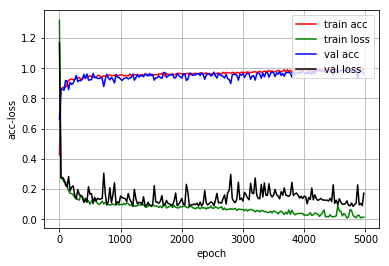

In [14]:
history.loss_plot('epoch')

In [8]:
def predict(model,data):
    tmp_res = model.predict(data)
    res = []
    for item in tmp_res:
        res.append(np.where(item == max(item))[0][0])
    return np.array(res)

In [9]:
y_true = class_train
y_pred = predict(model,data_train)
target_names = ['normal', 'cpu', 'mem', 'io']
print("train acc: {}".format(sum(y_true == y_pred)/float(len(y_true))))
print(classification_report(y_true, y_pred, target_names=target_names))

# print("test: {}".format(clf.score(mid_features_test, class_test)))
y_true = class_test
y_pred = predict(model,data_test)
print("test acc: {}".format(sum(y_true == y_pred)/float(len(y_true))))
print(classification_report(y_true, y_pred, target_names=target_names))

train acc: 0.999492127984
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       984
        cpu       1.00      1.00      1.00       299
        mem       1.00      1.00      1.00       212
         io       1.00      1.00      1.00       474

avg / total       1.00      1.00      1.00      1969

test acc: 0.991886409736
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       247
        cpu       0.97      1.00      0.99        74
        mem       1.00      0.96      0.98        54
         io       0.98      0.98      0.98       118

avg / total       0.99      0.99      0.99       493



## 神经网络 + SVM
45 => 128 => 64 => 32 => 16 => SVM

In [10]:
get_feature = K.function([model.layers[0].input],[model.layers[4].output])
mid_features_train = get_feature([data_train])[0]
mid_features_test  = get_feature([data_test])[0]
clf = svm.SVC()
clf.fit(mid_features_train, class_train)

print("train acc: {}".format(clf.score(mid_features_train, class_train)))
y_true = class_train
y_pred = clf.predict(mid_features_train)
target_names = ['normal', 'cpu', 'mem', 'io']
print(classification_report(y_true, y_pred, target_names=target_names))

print("test acc: {}".format(clf.score(mid_features_test, class_test)))
y_true = class_test
y_pred = clf.predict(mid_features_test)
print(classification_report(y_true, y_pred, target_names=target_names))

train acc: 0.982732351447
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       984
        cpu       0.95      0.94      0.95       299
        mem       0.95      0.99      0.97       212
         io       0.98      0.97      0.97       474

avg / total       0.98      0.98      0.98      1969

test acc: 0.975659229209
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       247
        cpu       0.96      0.92      0.94        74
        mem       0.93      0.94      0.94        54
         io       0.96      0.97      0.97       118

avg / total       0.98      0.98      0.98       493



## 其他机器学习算法
- KNN
- 线性SVM
- 基于核函数的SVM (RBF SVM), Radial basis function kernel
- 决策树
- 随机森林

In [12]:
classifiers = [
    KNeighborsClassifier(4),
    svm.SVC(kernel="linear", C=0.025),
    svm.SVC(),
    DecisionTreeClassifier(max_depth=3),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1)
    ]
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Decision Tree",
         "Random Forest"]
for name, clf in zip(names,classifiers):
    clf.fit(data_train,class_train)
    print(name)
    print("train acc: {}".format(clf.score(data_train, class_train)))
    y_true = class_train
    y_pred = clf.predict(data_train)
    target_names = ['normal', 'cpu', 'mem', 'io']
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    print("test acc: {}".format(clf.score(data_test, class_test)))
    y_true = class_test
    y_pred = clf.predict(data_test)
    print(classification_report(y_true, y_pred, target_names=target_names))
    print '\n'

Nearest Neighbors
train acc: 0.973590655155
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       984
        cpu       0.89      0.97      0.93       299
        mem       0.95      0.90      0.92       212
         io       0.98      0.96      0.97       474

avg / total       0.97      0.97      0.97      1969

test acc: 0.95537525355
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       247
        cpu       0.84      0.93      0.88        74
        mem       0.94      0.83      0.88        54
         io       0.95      0.93      0.94       118

avg / total       0.96      0.96      0.96       493



Linear SVM
train acc: 0.857287963433
             precision    recall  f1-score   support

     normal       1.00      1.00      1.00       984
        cpu       1.00      0.45      0.63       299
        mem       1.00      0.44      0.61       212
         io       0.63      1.00      